In [1]:
import pandas as pd

In [2]:
metadata = pd.read_csv("../data/csv/metadata.csv")
node_data = pd.read_csv("../data/csv/node.csv")
edge_data = pd.read_csv("../data/csv/edge.csv")

In [3]:
metadata

node_id       node_class  max_inventory         cost_type  edge_id  \
0       0.0   raw_material_1          200.0  negative_dynamic      NaN   
1       1.0   raw_material_2          250.0  negative_dynamic      NaN   
2       2.0   raw_material_3          220.0  negative_dynamic      NaN   
3       3.0  intermediate_a1          300.0             fixed      NaN   
4       4.0  intermediate_a2          280.0  positive_dynamic      NaN   
5       5.0  intermediate_b1          300.0  positive_dynamic      NaN   
6       6.0  intermediate_b2          280.0  negative_dynamic      NaN   
7       7.0    final_product          350.0  positive_dynamic      NaN   
8       8.0             sink            inf             fixed      NaN   
9       NaN              NaN            NaN               NaN      0.0   
10      NaN              NaN            NaN               NaN      1.0   
11      NaN              NaN            NaN               NaN      2.0   
12      NaN              NaN            NaN               NaN      3.0   
13      NaN              NaN            NaN               NaN      4.0   
14      NaN              NaN            NaN               NaN      5.0   
15      NaN              NaN            NaN               NaN      6.0   
16      NaN              NaN            NaN               NaN      7.0   
17      NaN              NaN            NaN               NaN      8.0   
18      NaN              NaN            NaN               NaN      9.0   

    source_node_id  target_node_id  unit_price  min_cost  max_cost  
0              NaN             NaN         NaN       NaN       NaN  
1              NaN             NaN         NaN       NaN       NaN  
2              NaN             NaN         NaN       NaN       NaN  
3              NaN             NaN         NaN       NaN       NaN  
4              NaN             NaN         NaN       NaN       NaN  
5              NaN             NaN         NaN       NaN       NaN  
6              NaN             NaN         NaN       NaN       NaN  
7              NaN             NaN         NaN       NaN       NaN  
8              NaN             NaN         NaN       NaN       NaN  
9              0.0             3.0        10.0       5.0      15.0  
10             1.0             3.0        15.0       8.0      20.0  
11             1.0             4.0        12.0       6.0      18.0  
12             2.0             4.0        14.0       7.0      19.0  
13             3.0             5.0        20.0      10.0      25.0  
14             4.0             5.0        22.0      11.0      27.0  
15             5.0             7.0        20.0      10.0      25.0  
16             6.0             7.0        22.0      11.0      27.0  
17             2.0             7.0        18.0       9.0      23.0  
18             7.0             8.0        25.0      13.0      30.0

In [4]:
node_data

cycle  node_id  inventory  last_production
0        0        0          0               10
1        1        0          0               10
2        2        0          0               10
3        3        0          0               10
4        4        0          0               10
..     ...      ...        ...              ...
175     15        8        538              250
176     16        8        555              250
177     17        8        594              250
178     18        8        611              250
179     19        8        650              250

[180 rows x 4 columns]

In [5]:
edge_data

cycle  edge_id  quantity  current_cost
0        0        0        30          15.0
1        1        0        10          15.0
2        2        0        10          15.0
3        3        0        10          15.0
4        4        0        10          15.0
..     ...      ...       ...           ...
195     15        9       289          13.0
196     16        9       267          13.0
197     17        9       289          13.0
198     18        9       267          13.0
199     19        9       289          13.0

[200 rows x 4 columns]

### Conversion to NetworkX

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def convert_to_graph(metadata, node, edge):
    graphs = []
    unique_cycles = node['cycle'].unique()
    
    for cycle in unique_cycles:
        G = nx.DiGraph()
        
        # Add nodes
        cycle_nodes = node[node['cycle'] == cycle]
        for _, row in cycle_nodes.iterrows():
            node_id = row['node_id']
            node_data = metadata[metadata['node_id'] == node_id].iloc[0].to_dict() if not metadata[metadata['node_id'] == node_id].empty else {}
            node_data.update(row.to_dict())
            G.add_node(node_id, **node_data)
        
        # Add edges
        cycle_edges = edge[edge['cycle'] == cycle]
        for _, row in cycle_edges.iterrows():
            edge_id = row['edge_id']
            edge_data = metadata[metadata['edge_id'] == edge_id].iloc[0].to_dict() if not metadata[metadata['edge_id'] == edge_id].empty else {}
            edge_data.update(row.to_dict())
            source = edge_data.get('source_node_id')
            target = edge_data.get('target_node_id')
            if source and target:
                G.add_edge(source, target, **edge_data)
        
        graphs.append(G)
    
    return graphs

def visualize_graph(G, cycle):
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.8)
    
    # Prepare node labels with more properties
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{node}\n{data.get('node_class', 'N/A')}\n"
        label += f"Inventory: {data.get('inventory', 'N/A')}\n"
        label += f"Max Inv: {data.get('max_inventory', 'N/A')}\n"
        label += f"Cost Type: {data.get('cost_type', 'N/A')}\n"
        label += f"Last Prod: {data.get('last_production', 'N/A')}"
        labels[node] = label
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8, verticalalignment='center')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        label = f"Edge: {data['edge_id']}\n"
        label += f"Quantity: {data['quantity']:.2f}\n"
        label += f"Current Cost: {data['current_cost']:.2f}\n"
        label += f"Unit Price: {data['unit_price']:.2f}"
        edge_labels[(u, v)] = label
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    
    plt.title(f"Supply Chain Network - Cycle {cycle}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

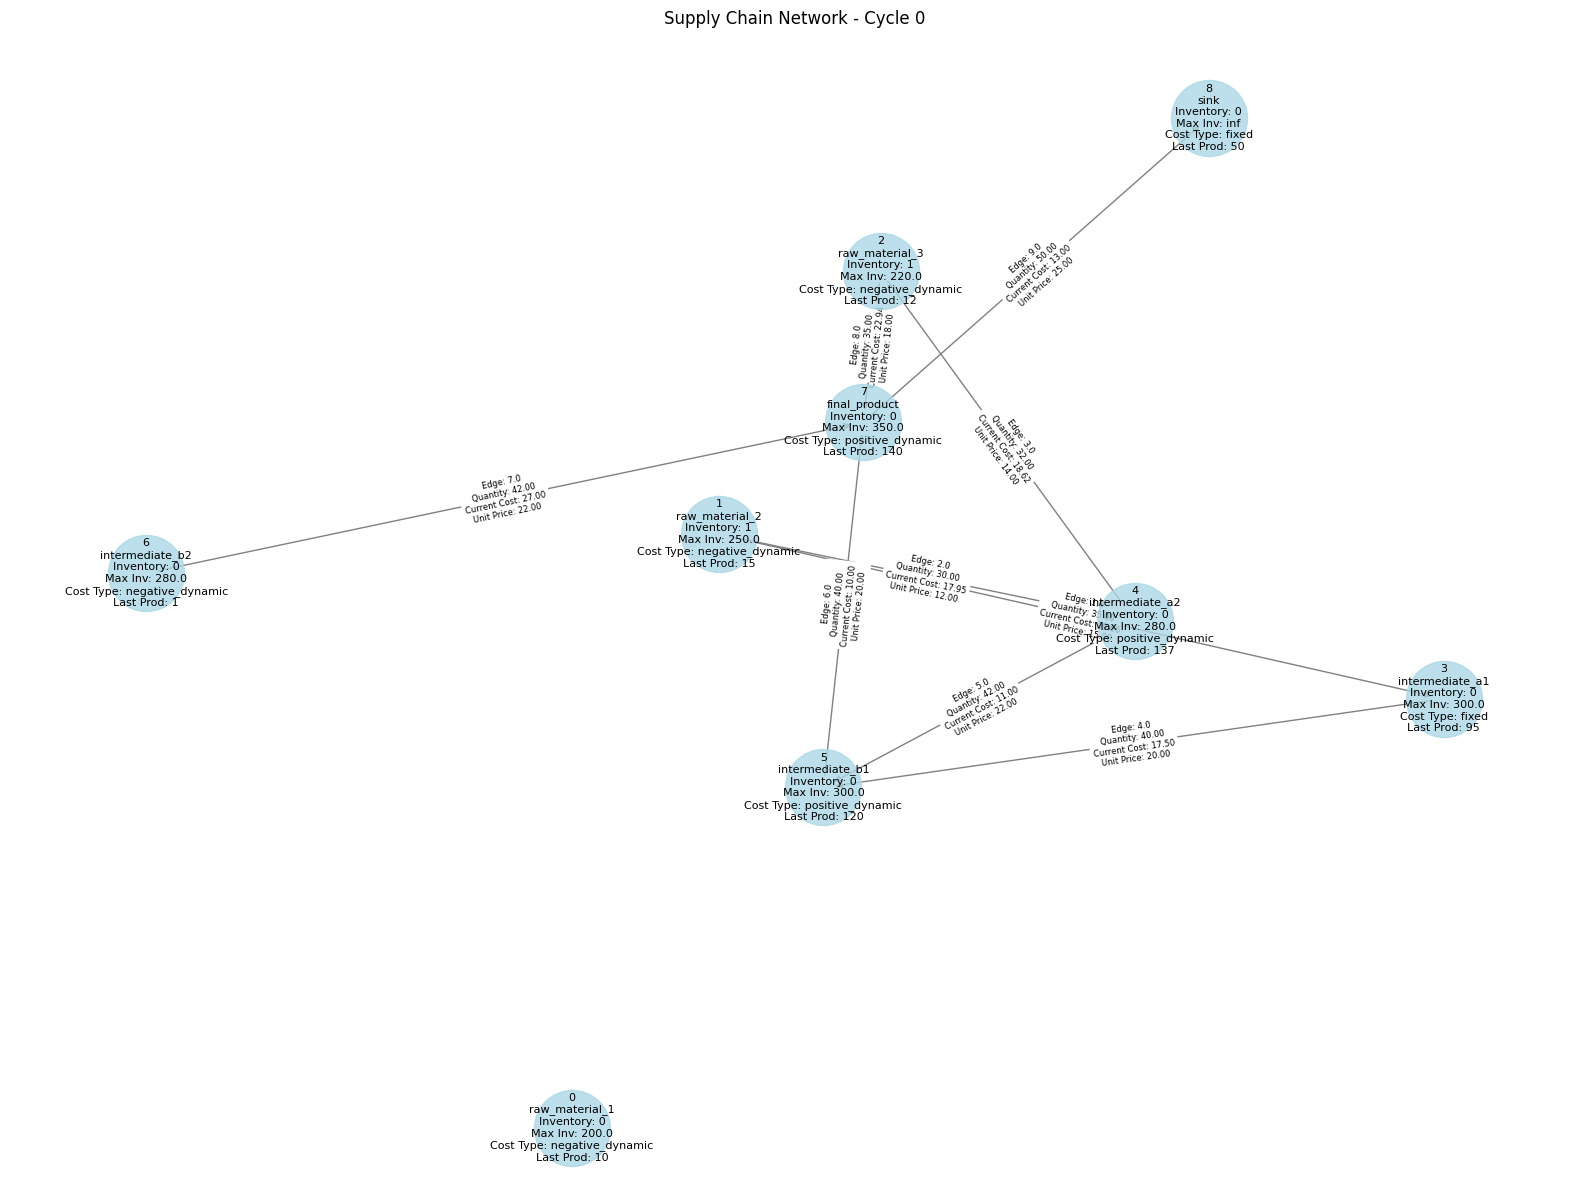

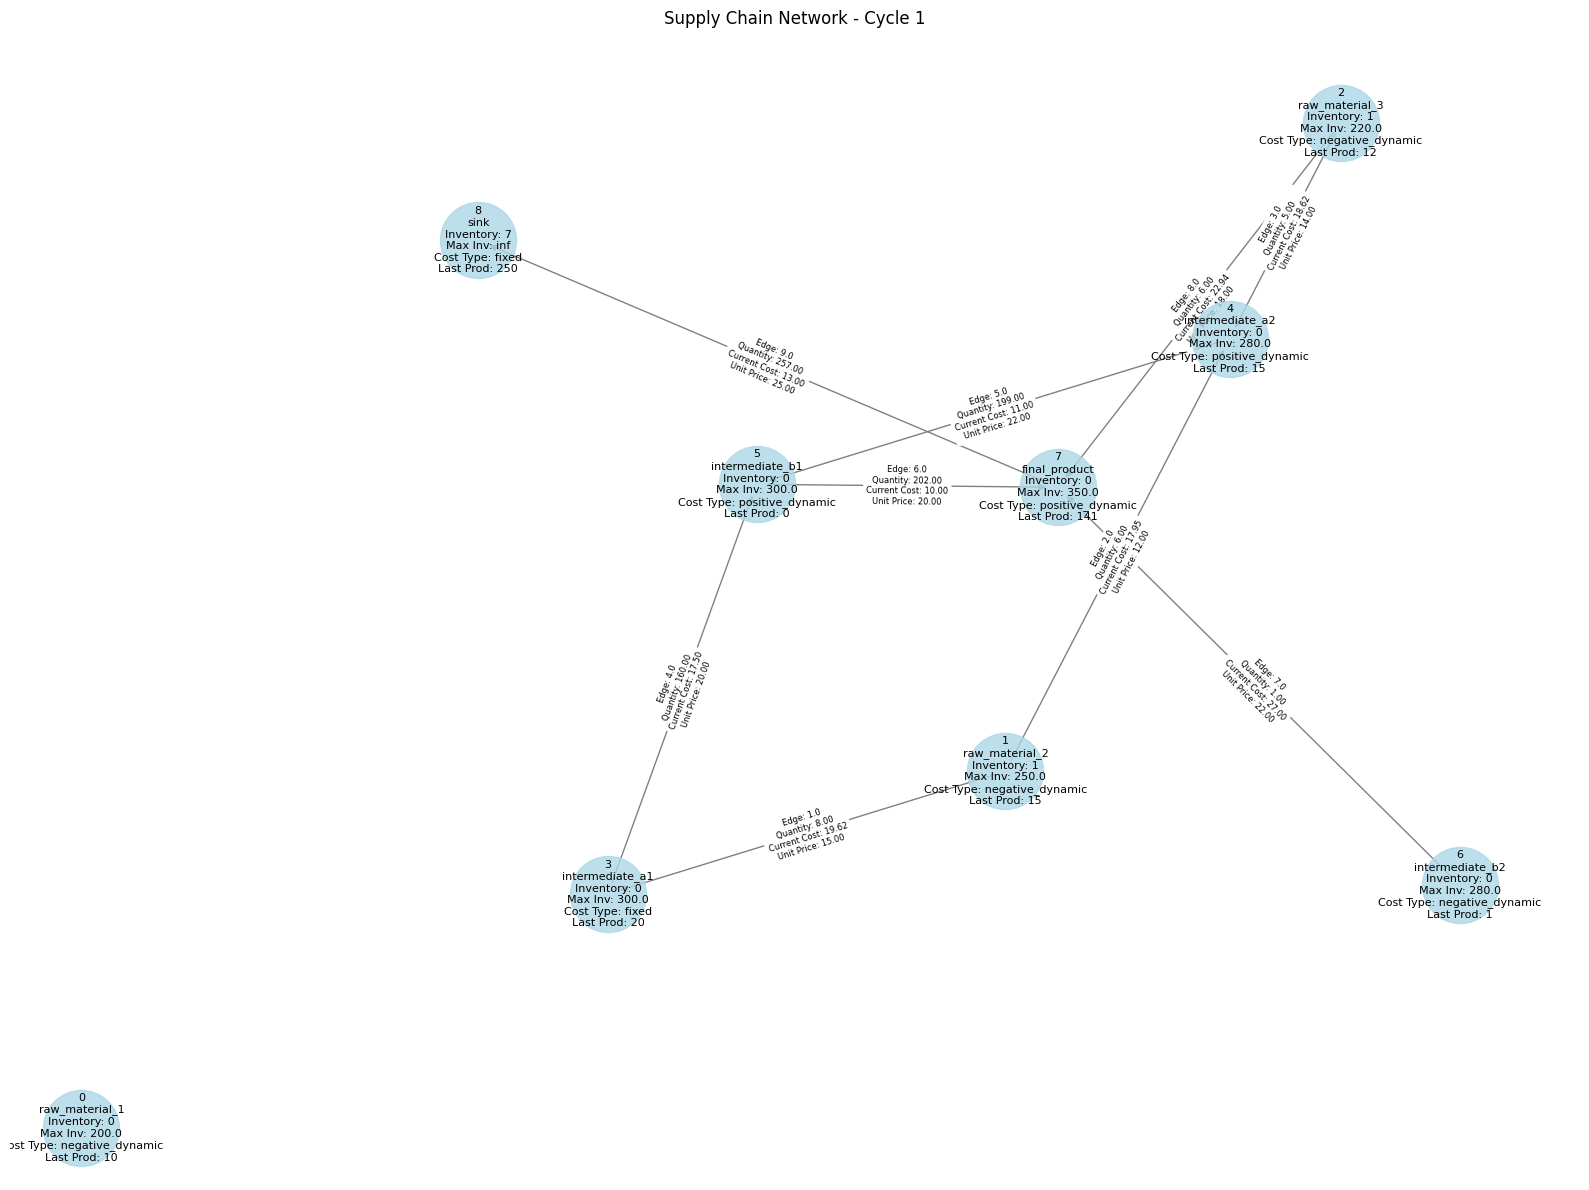

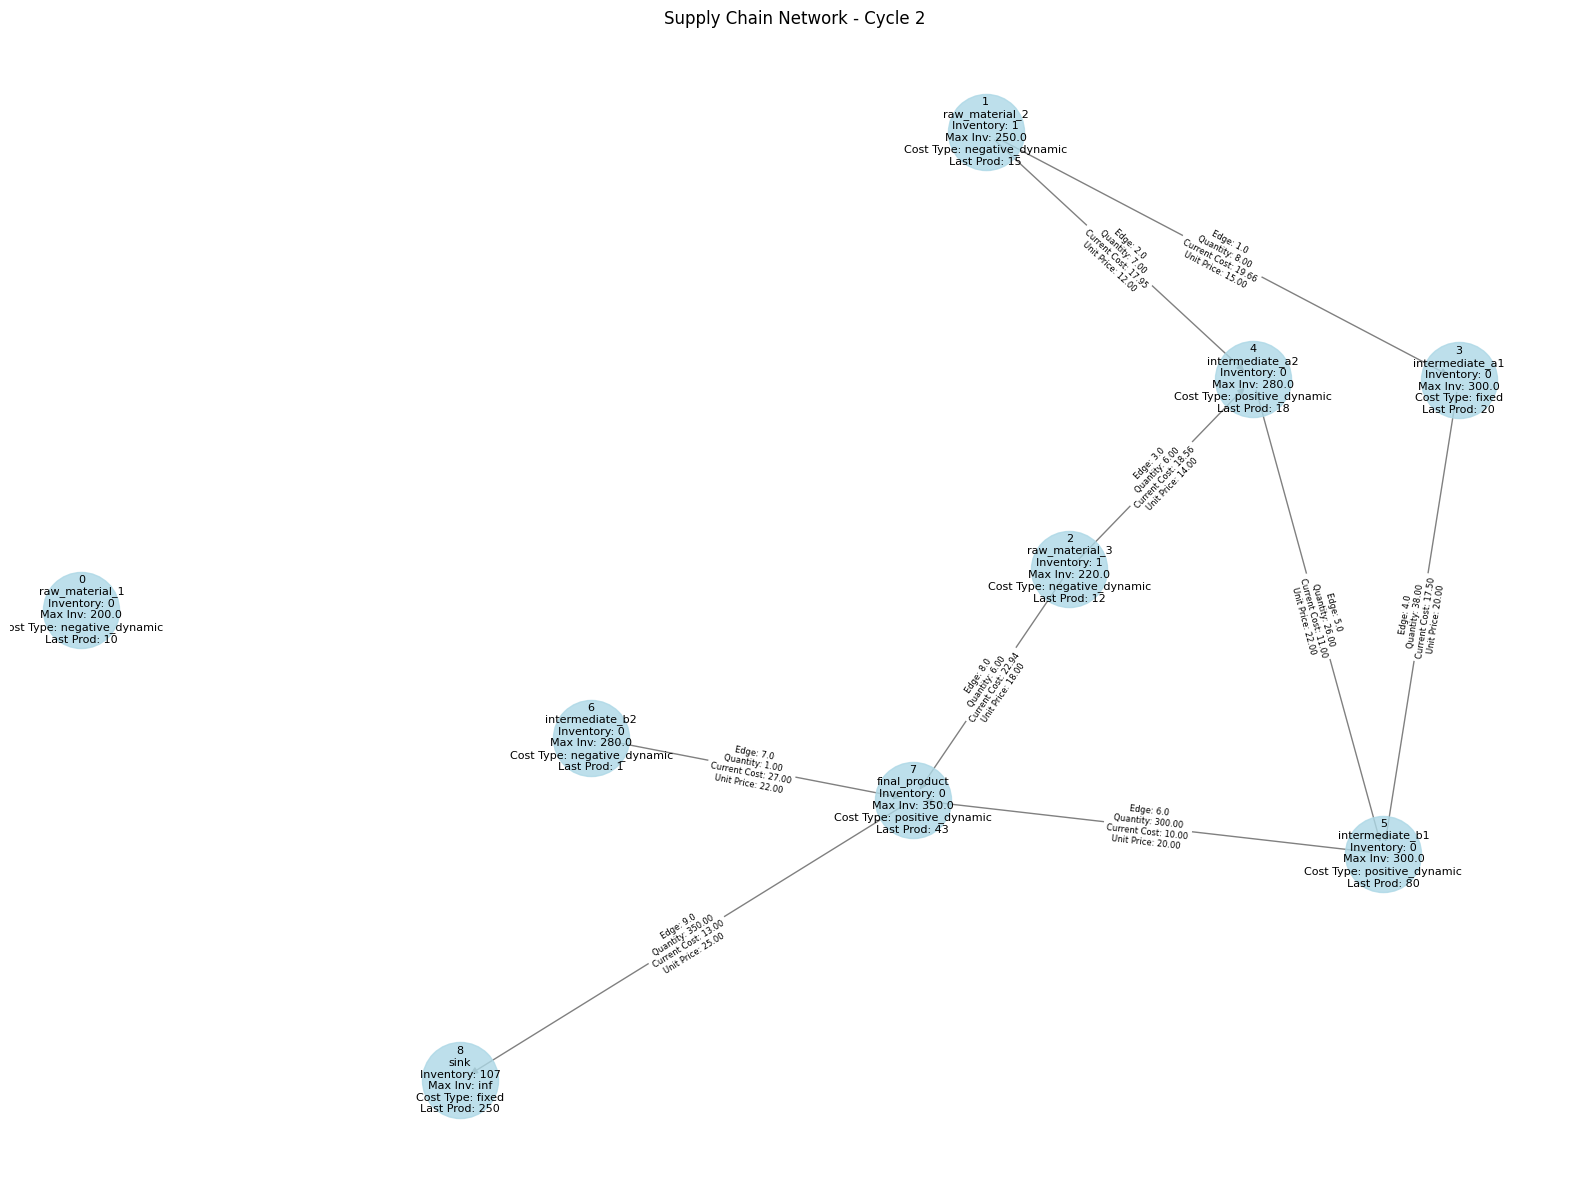

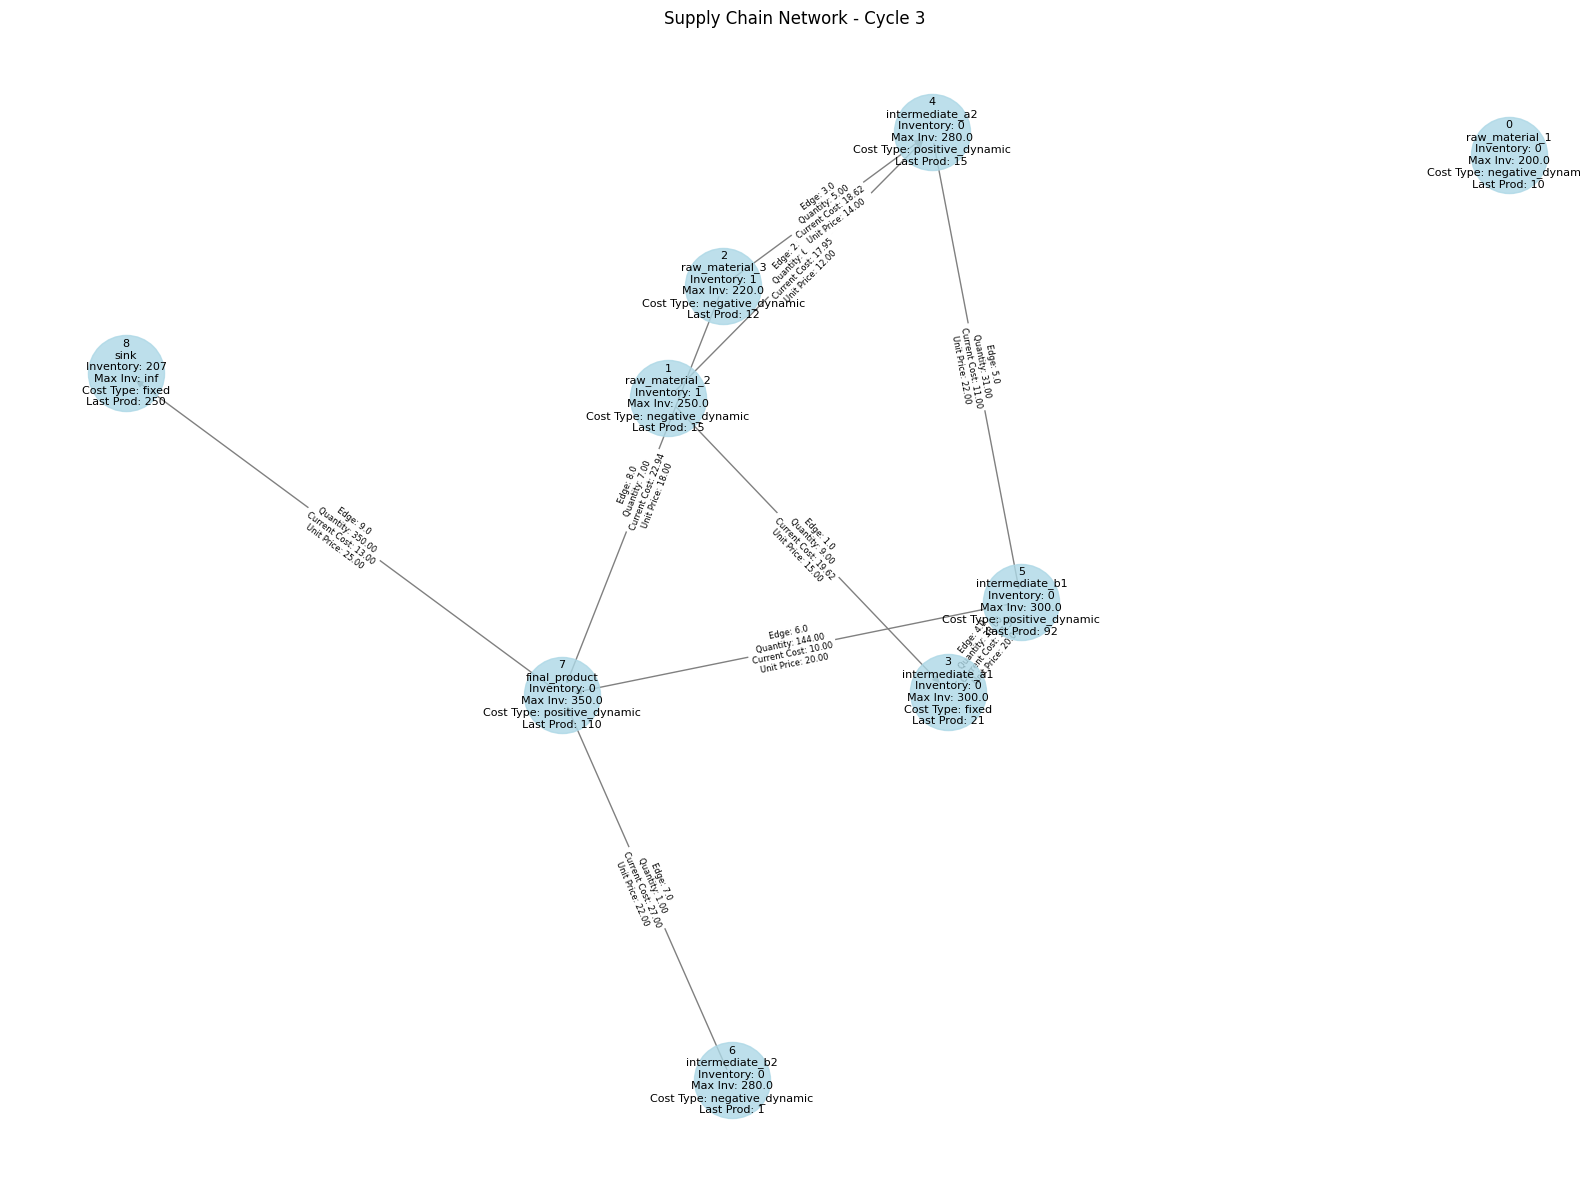

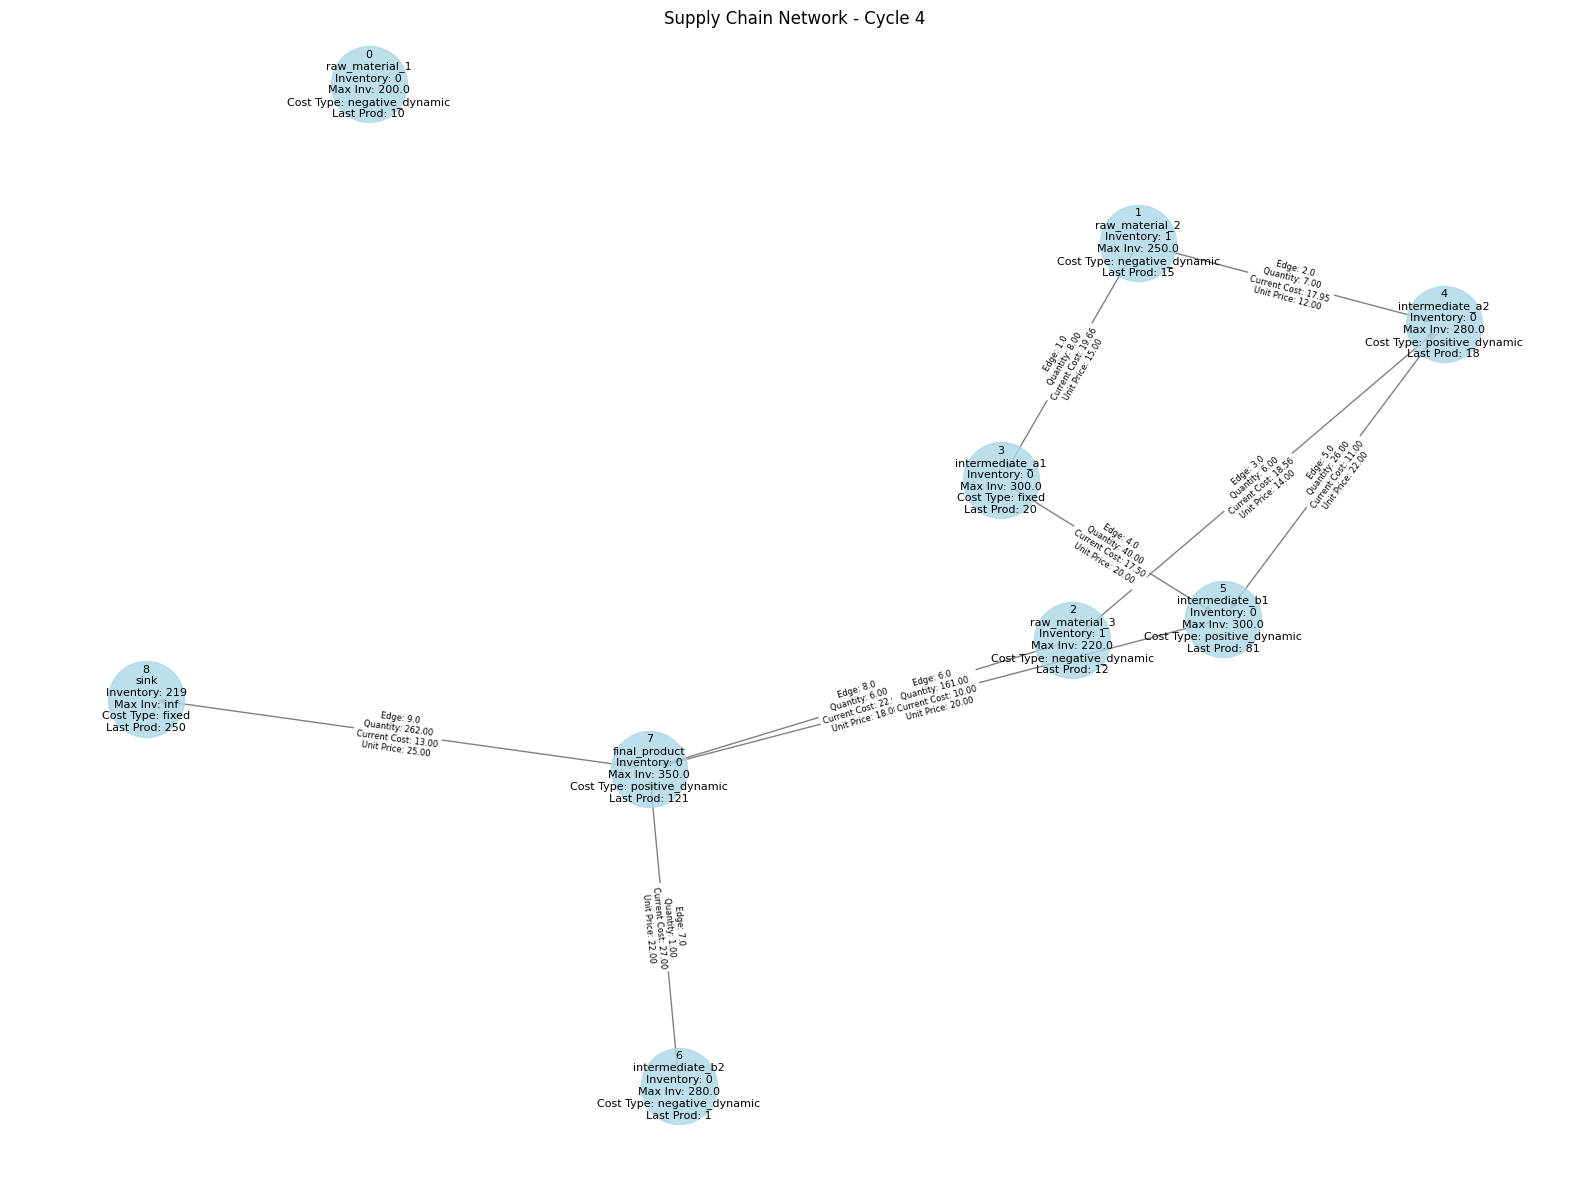

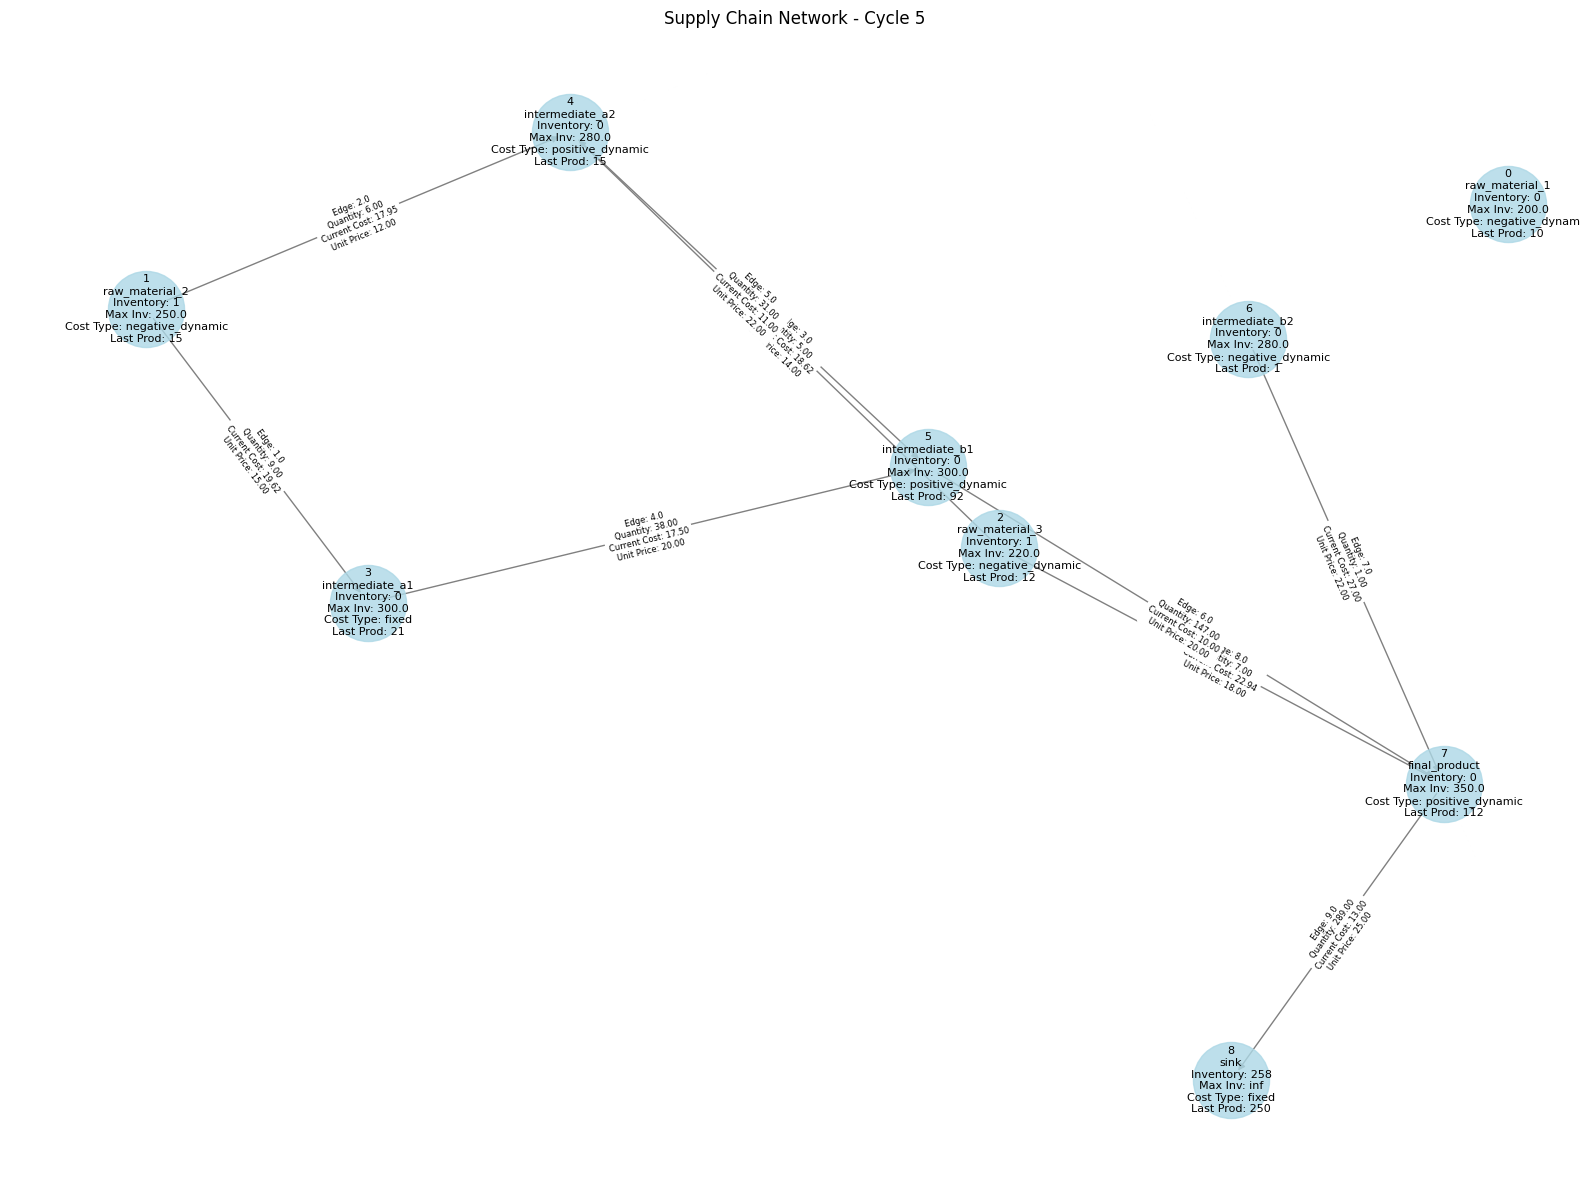

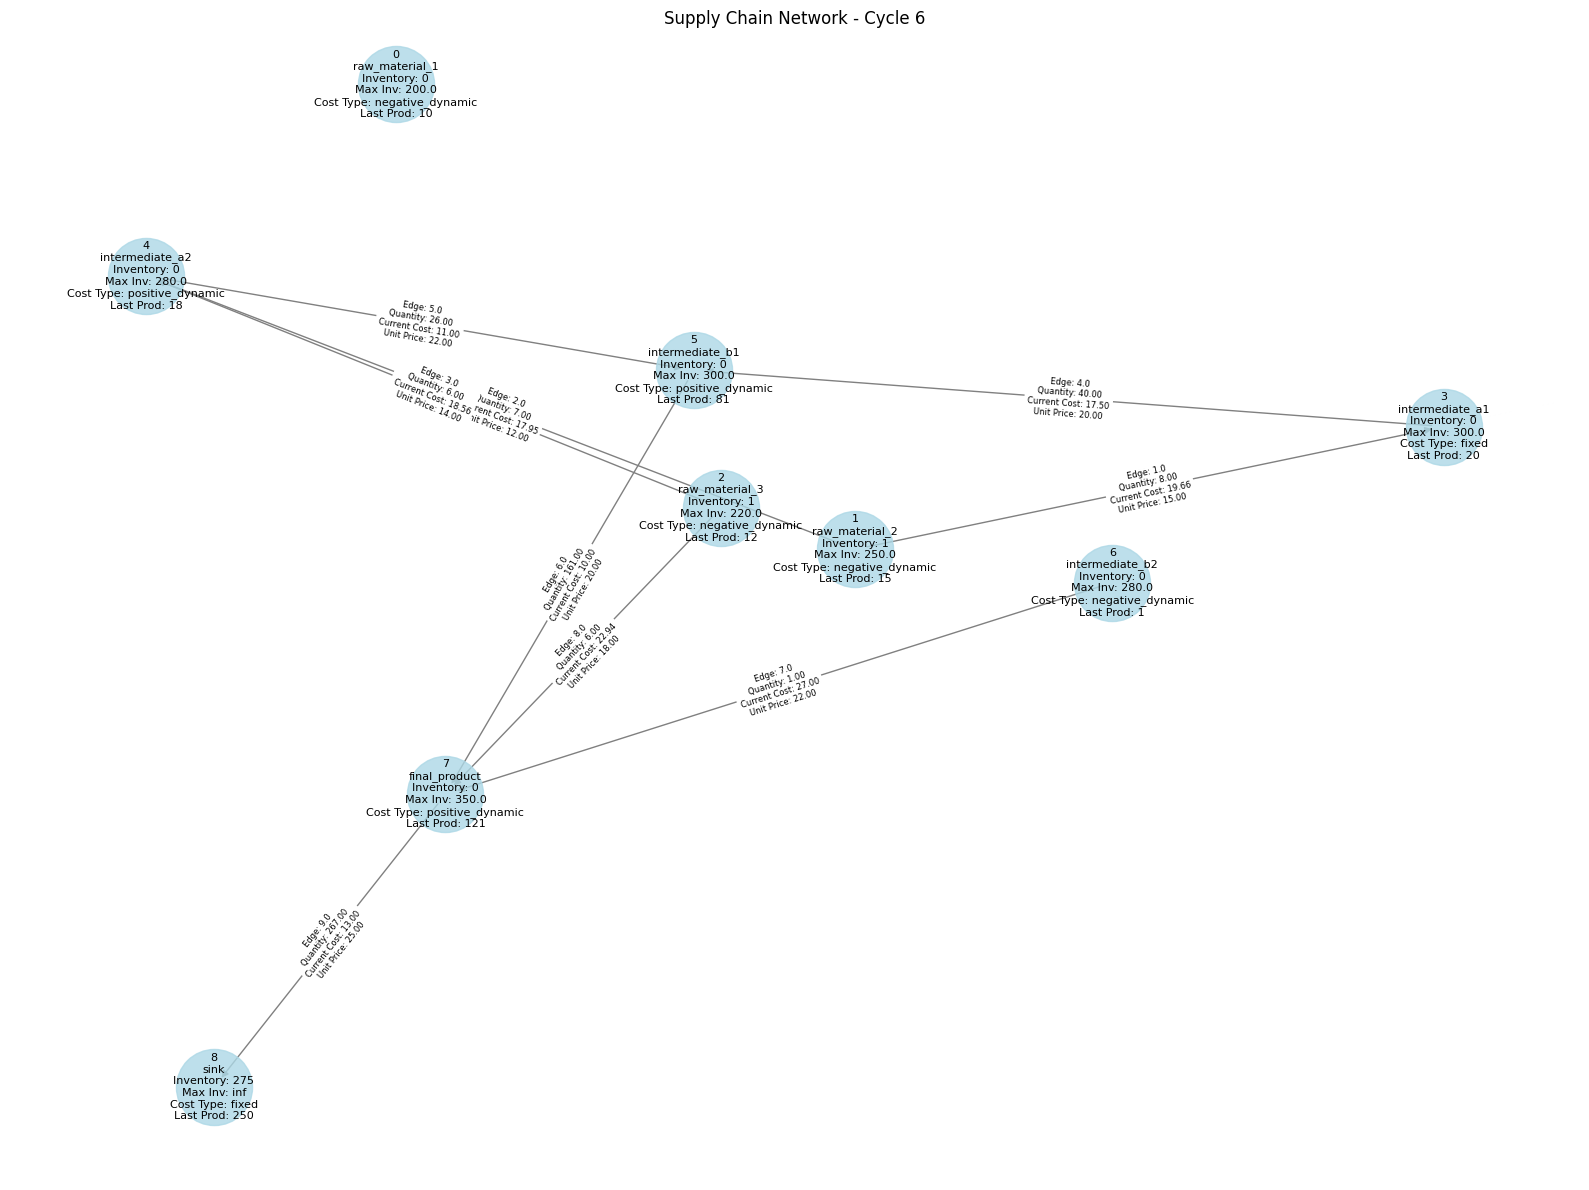

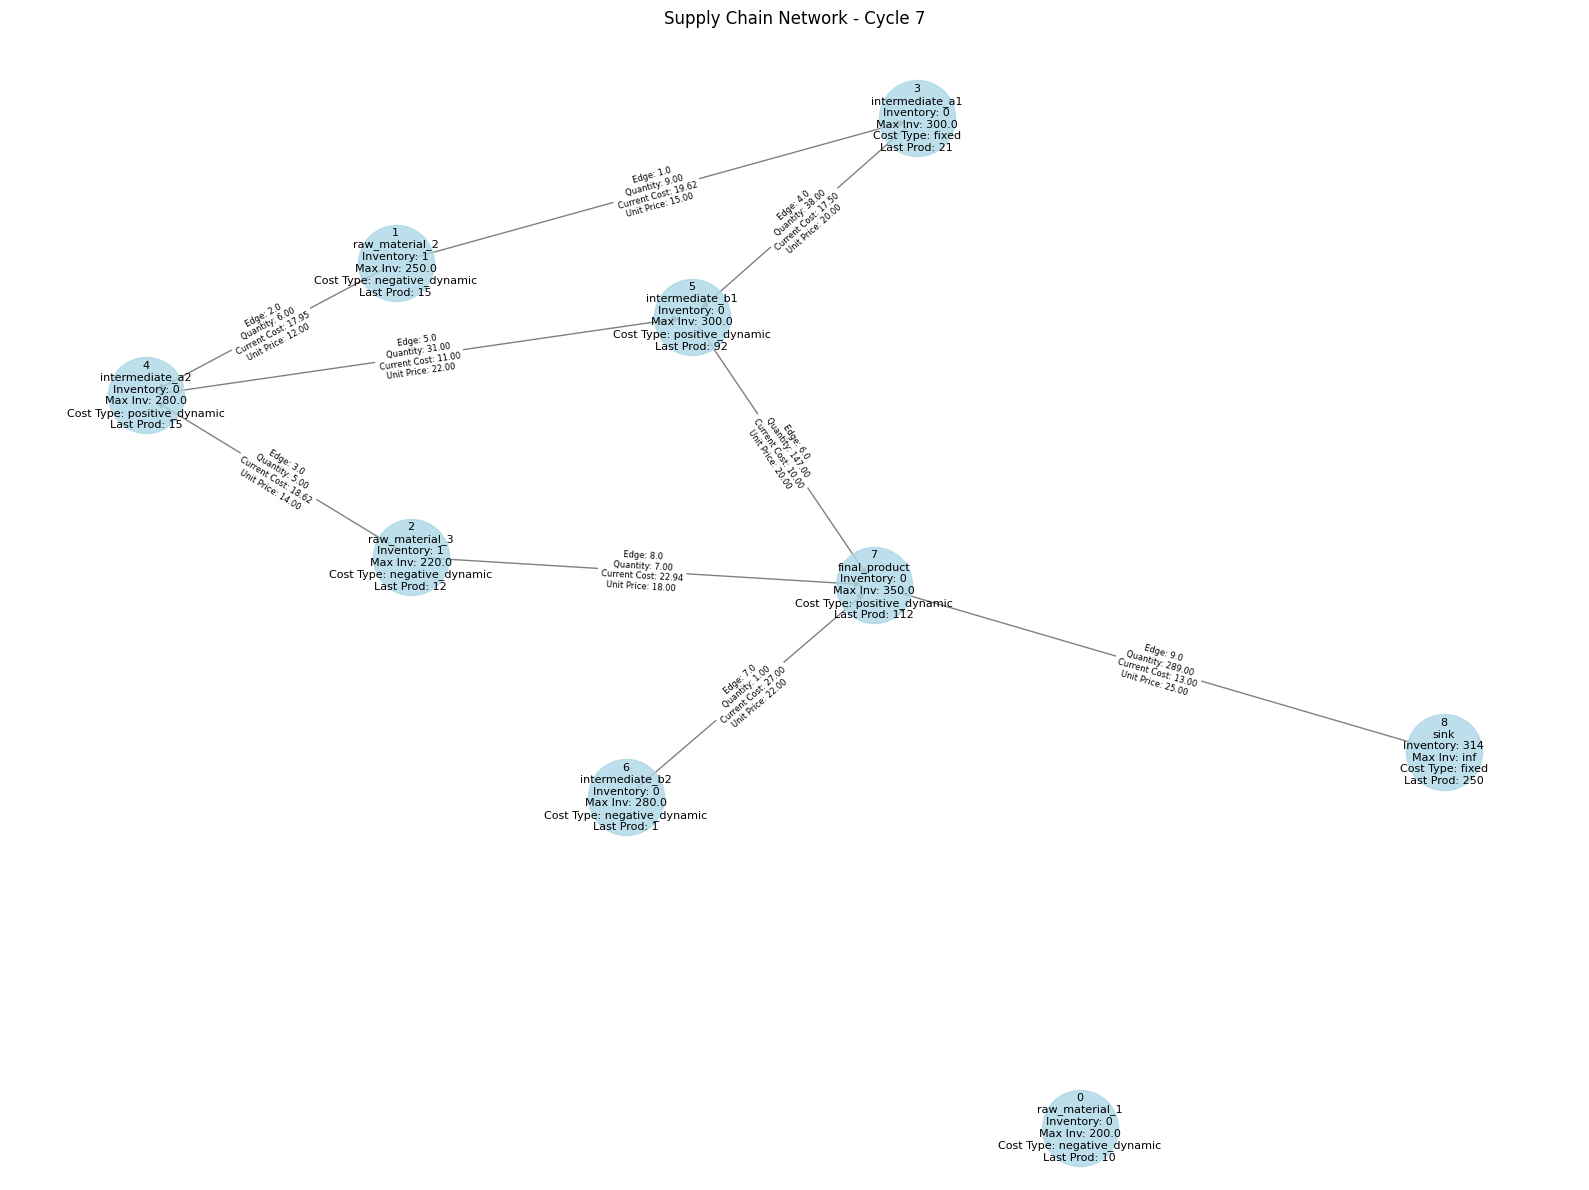

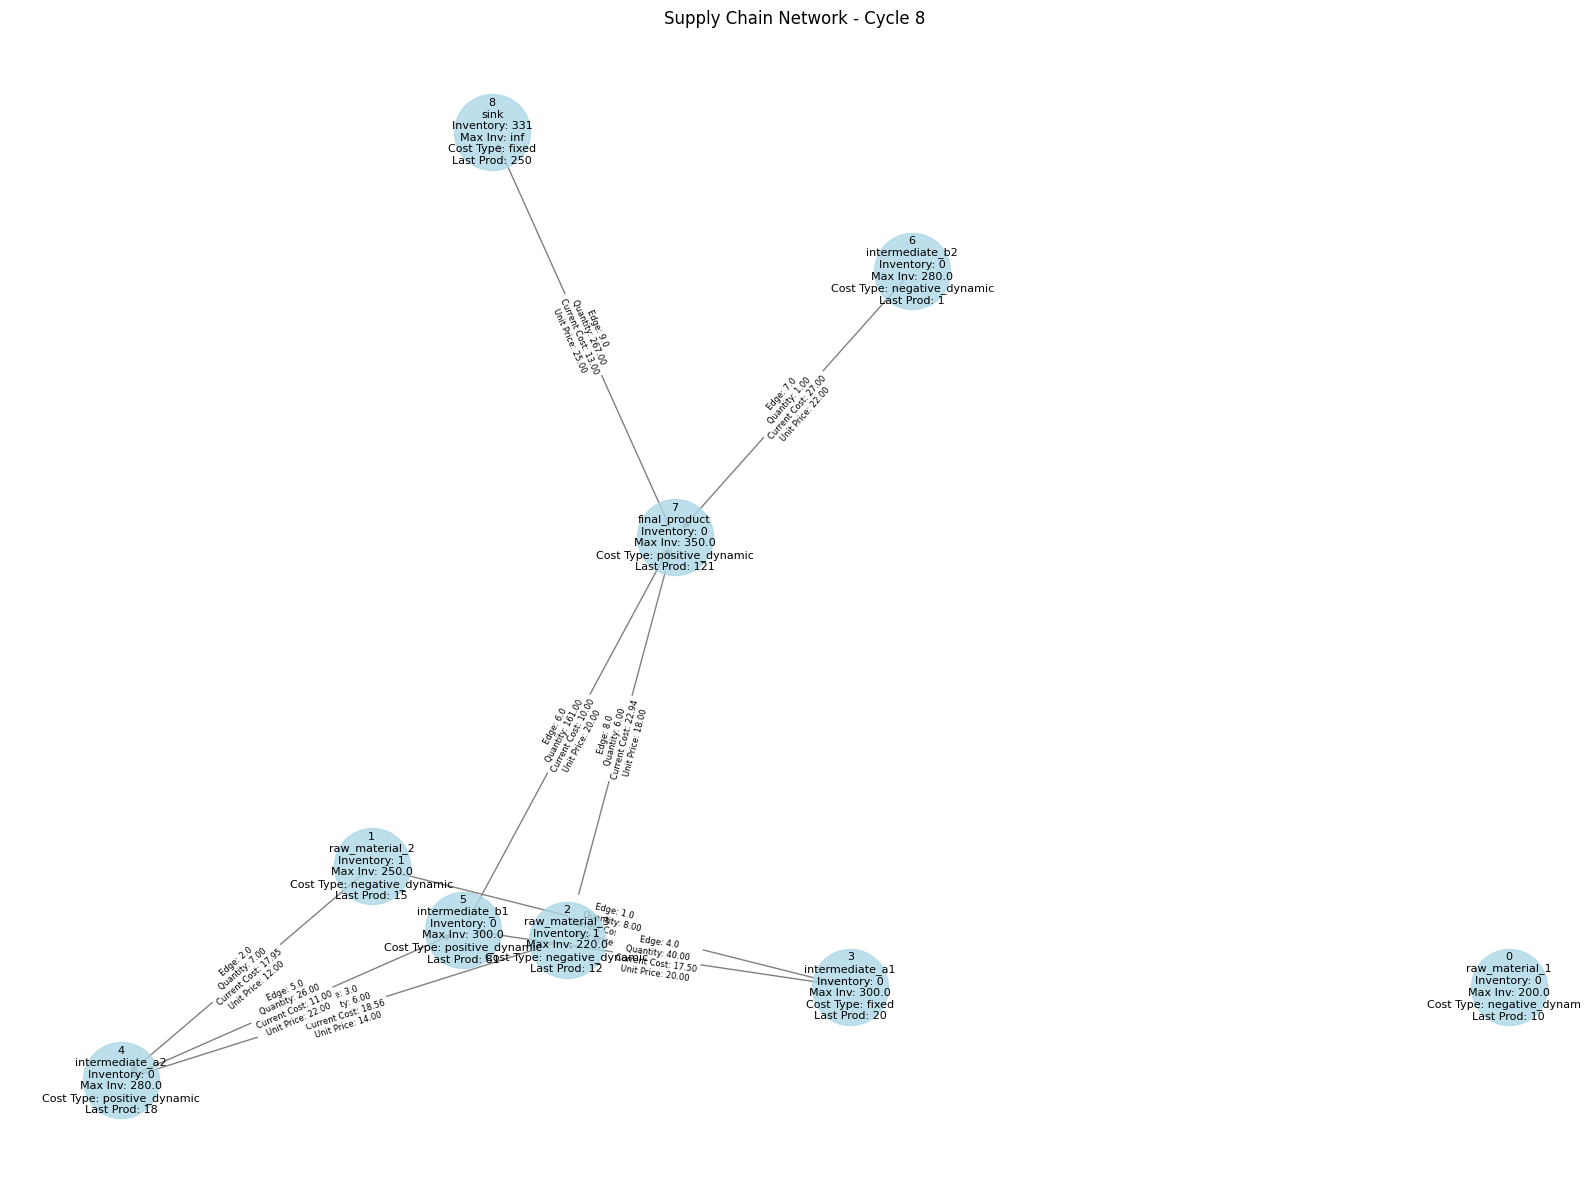

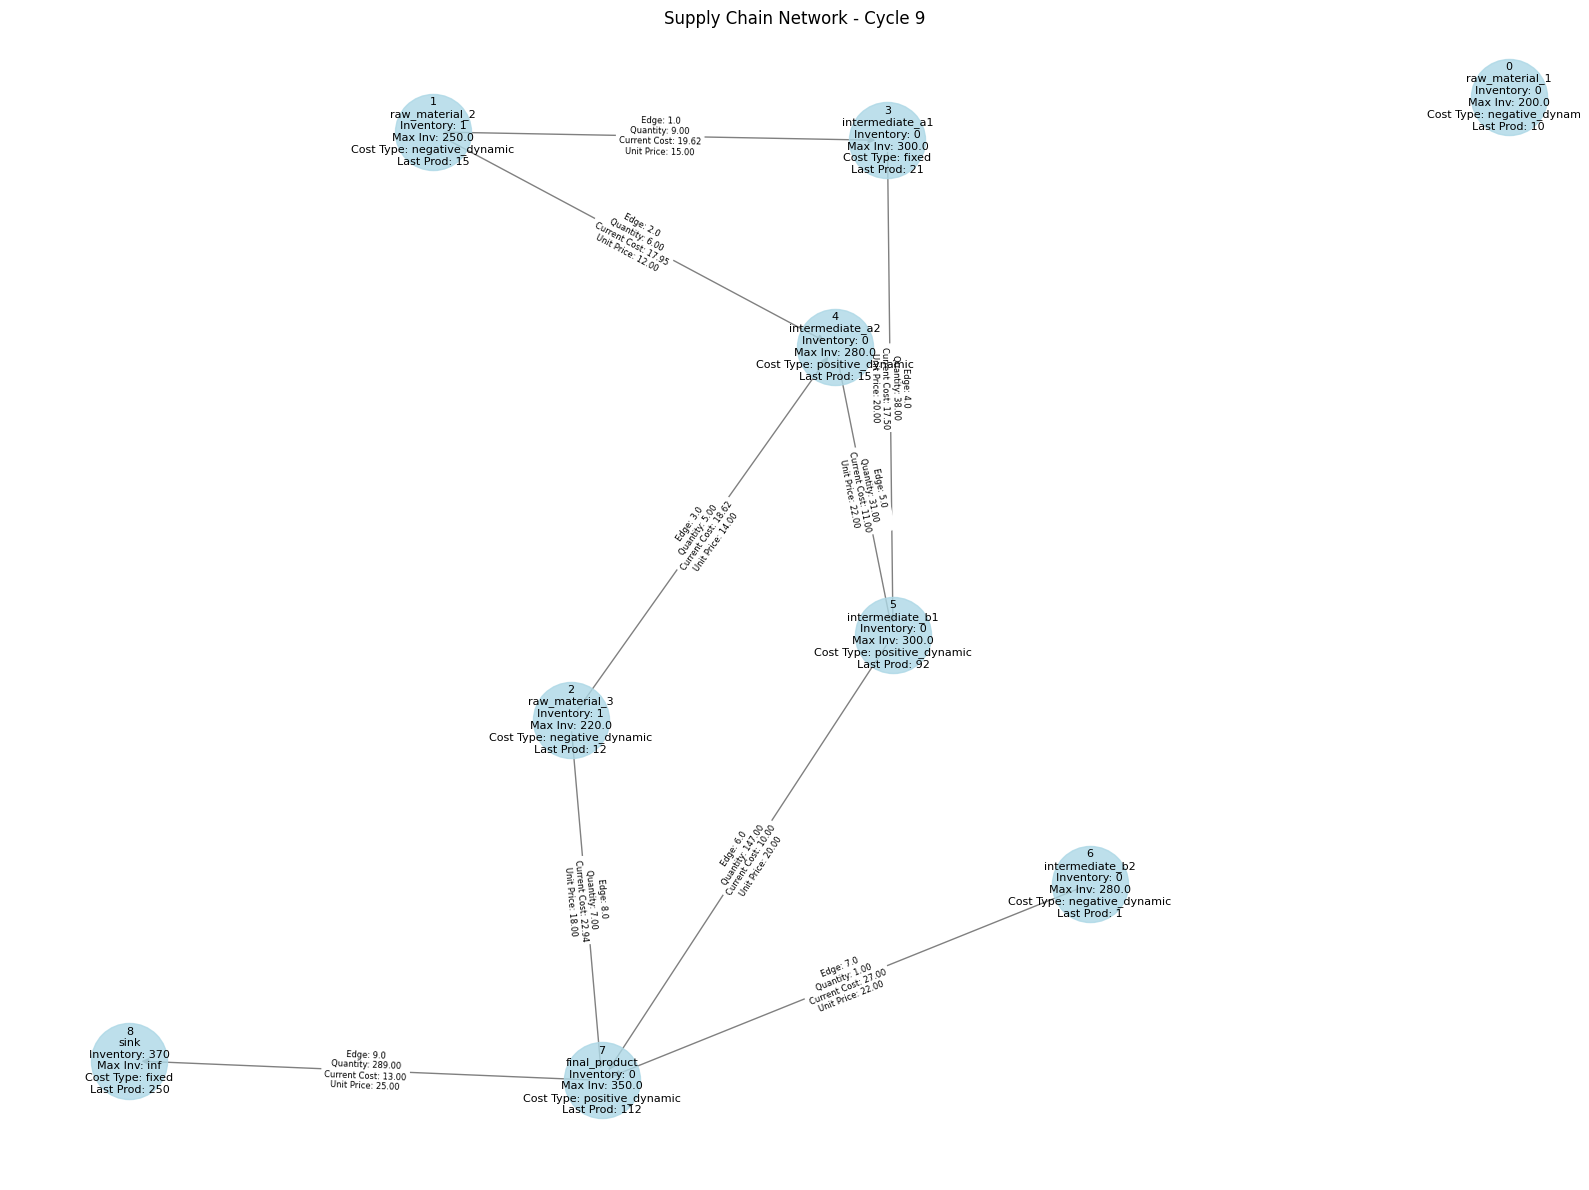

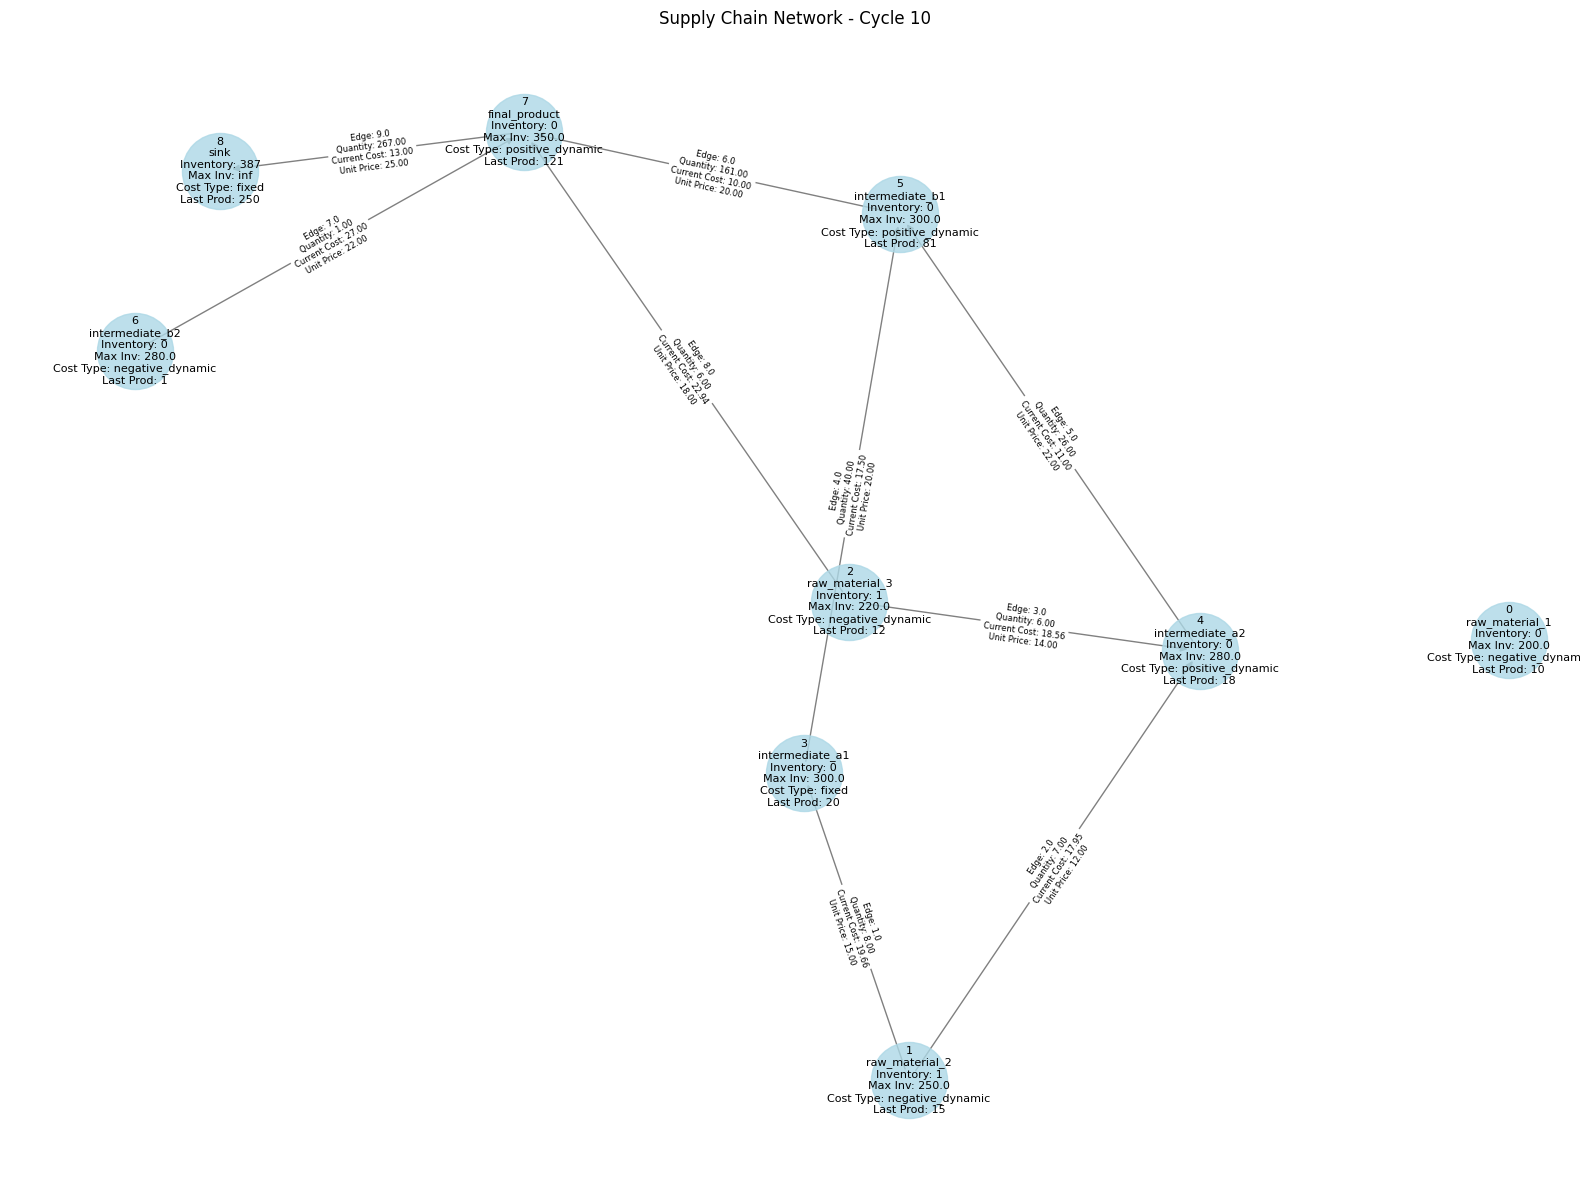

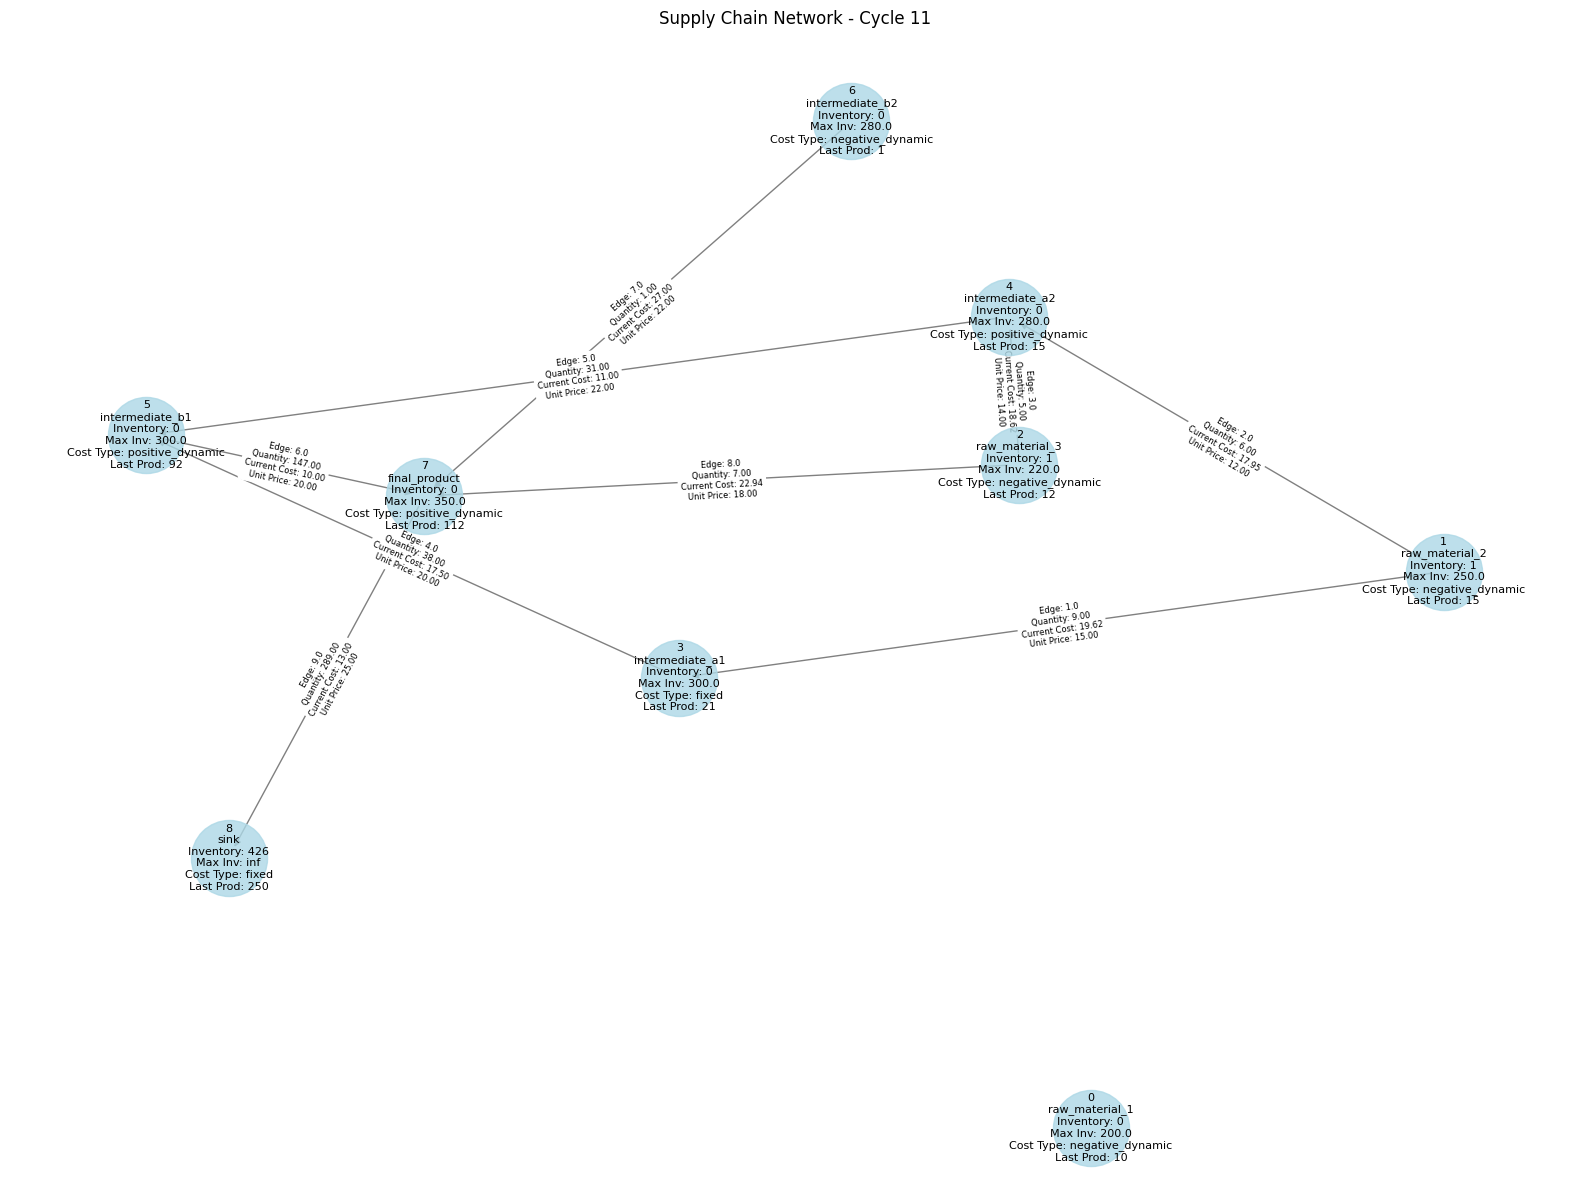

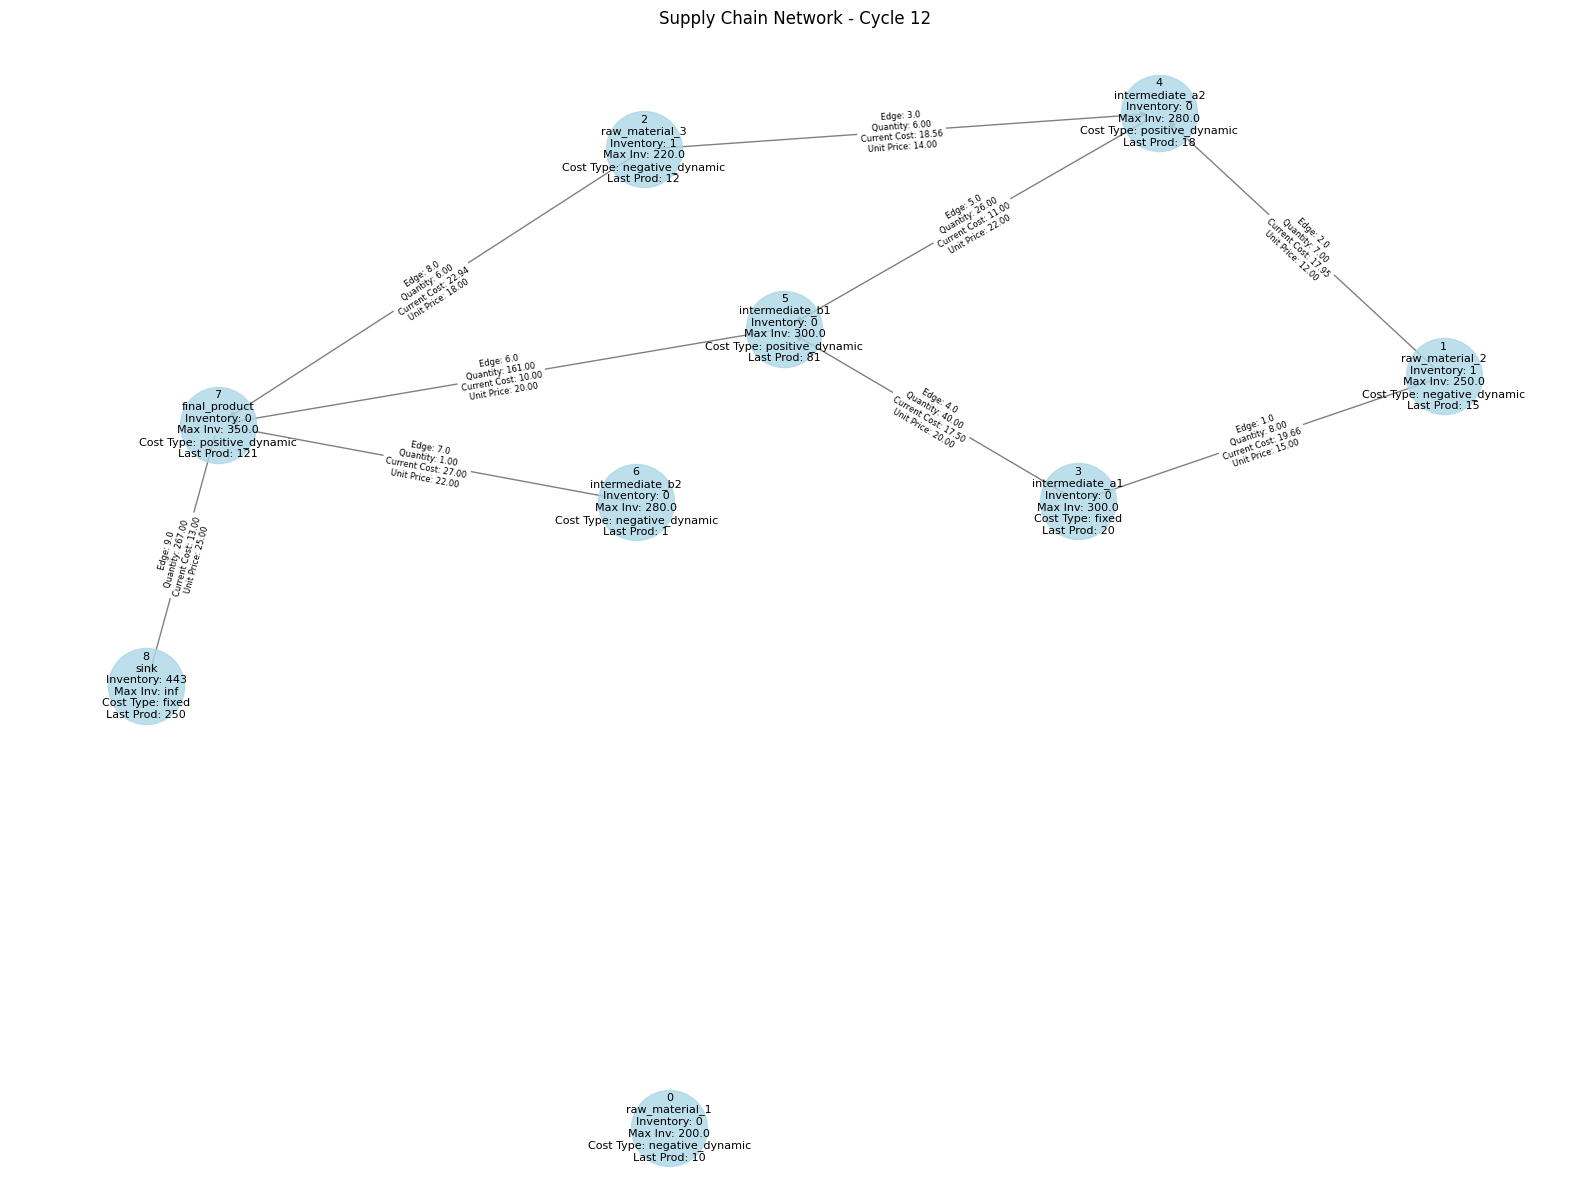

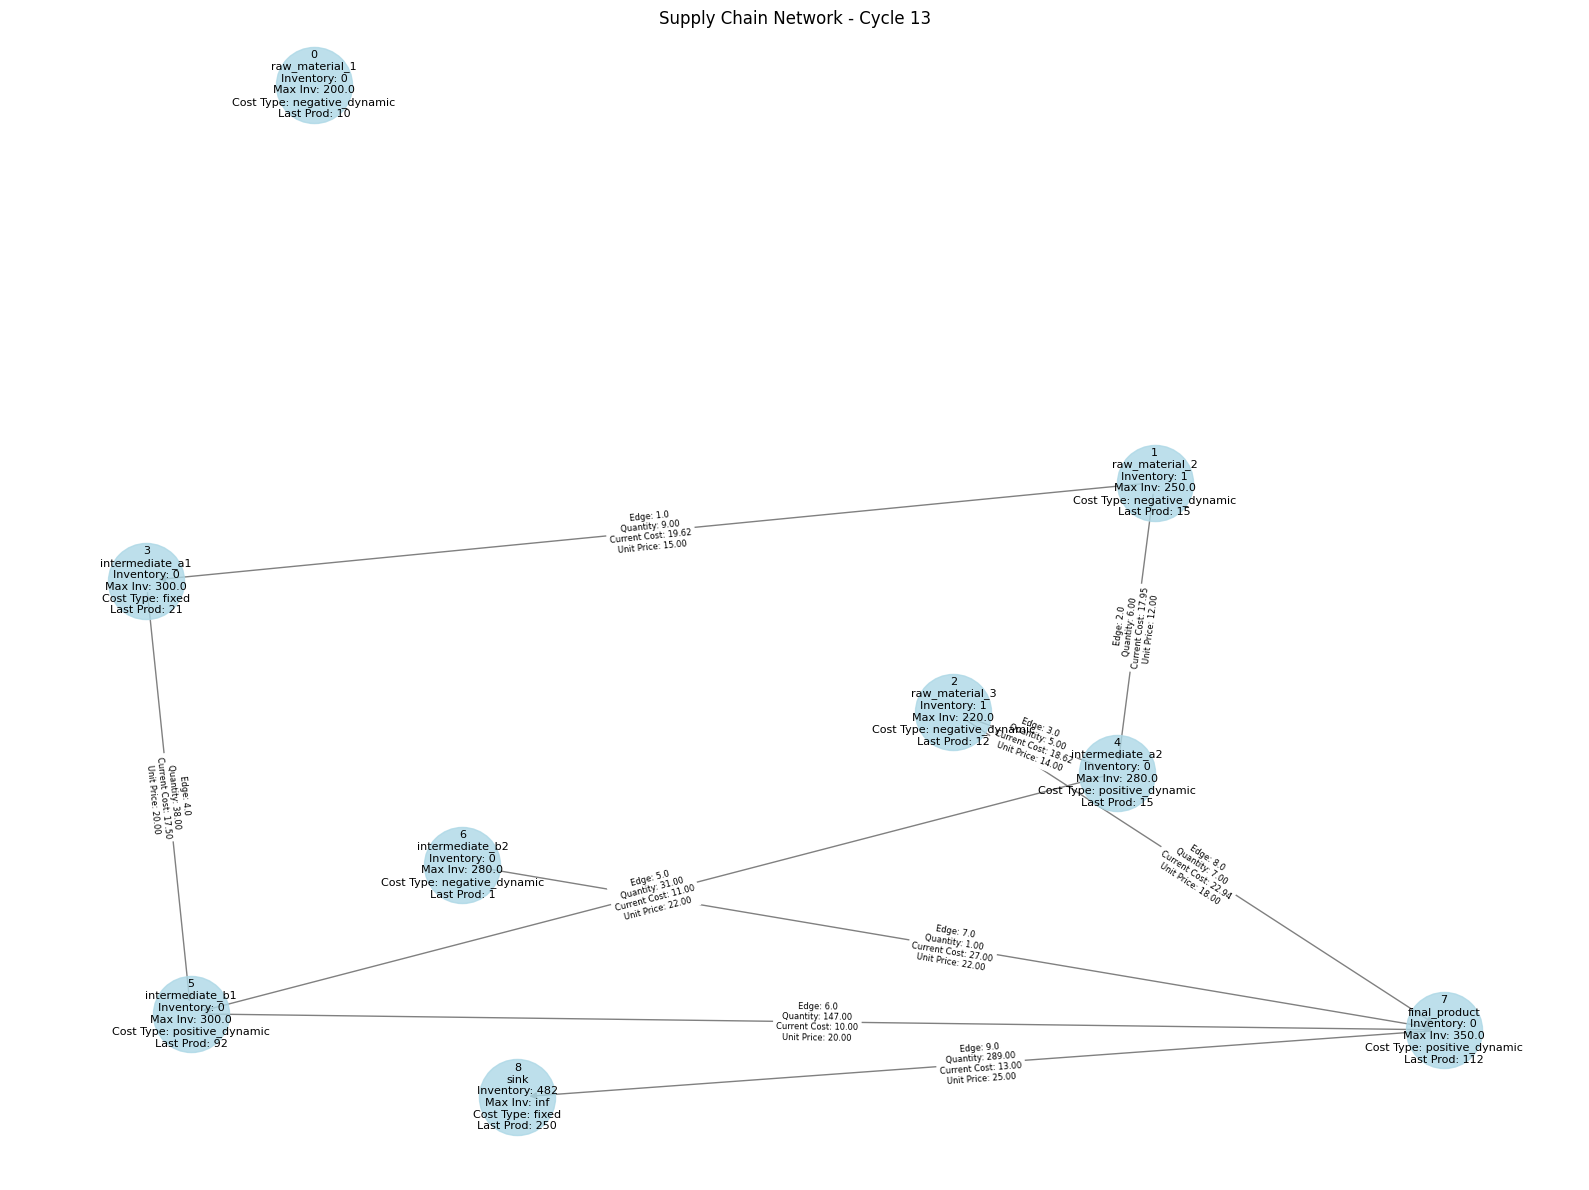

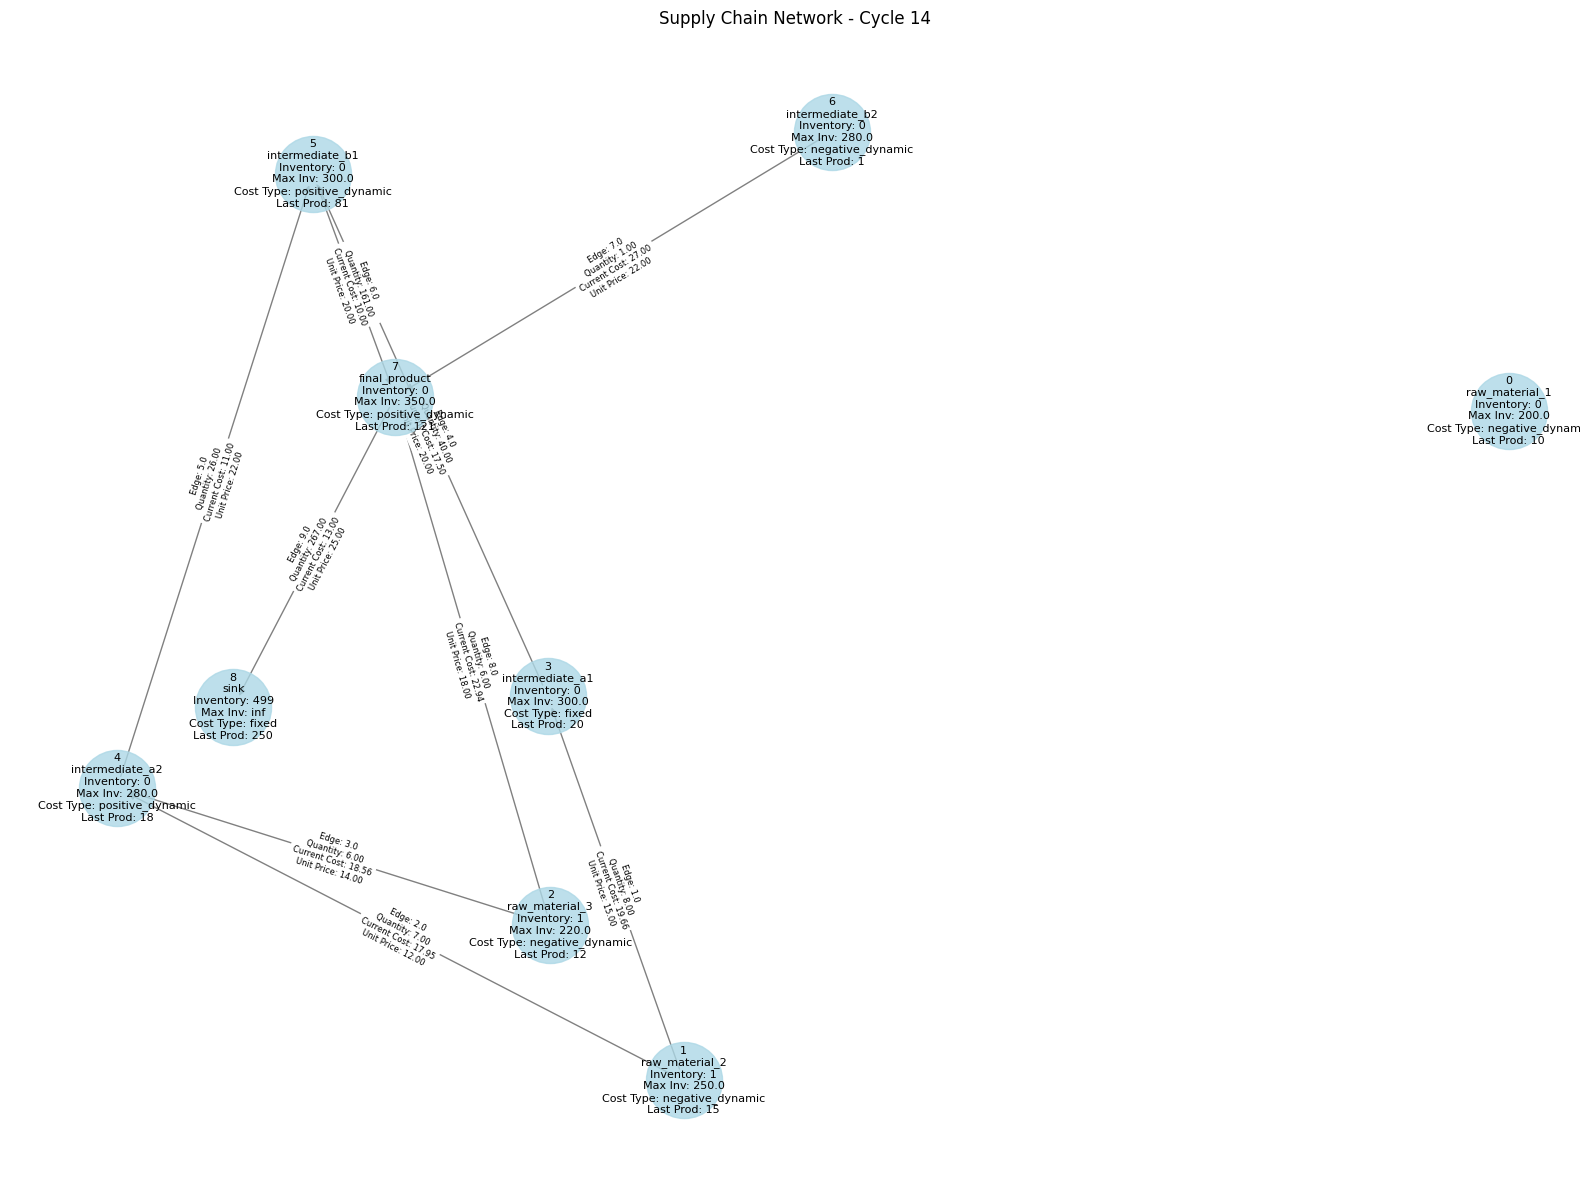

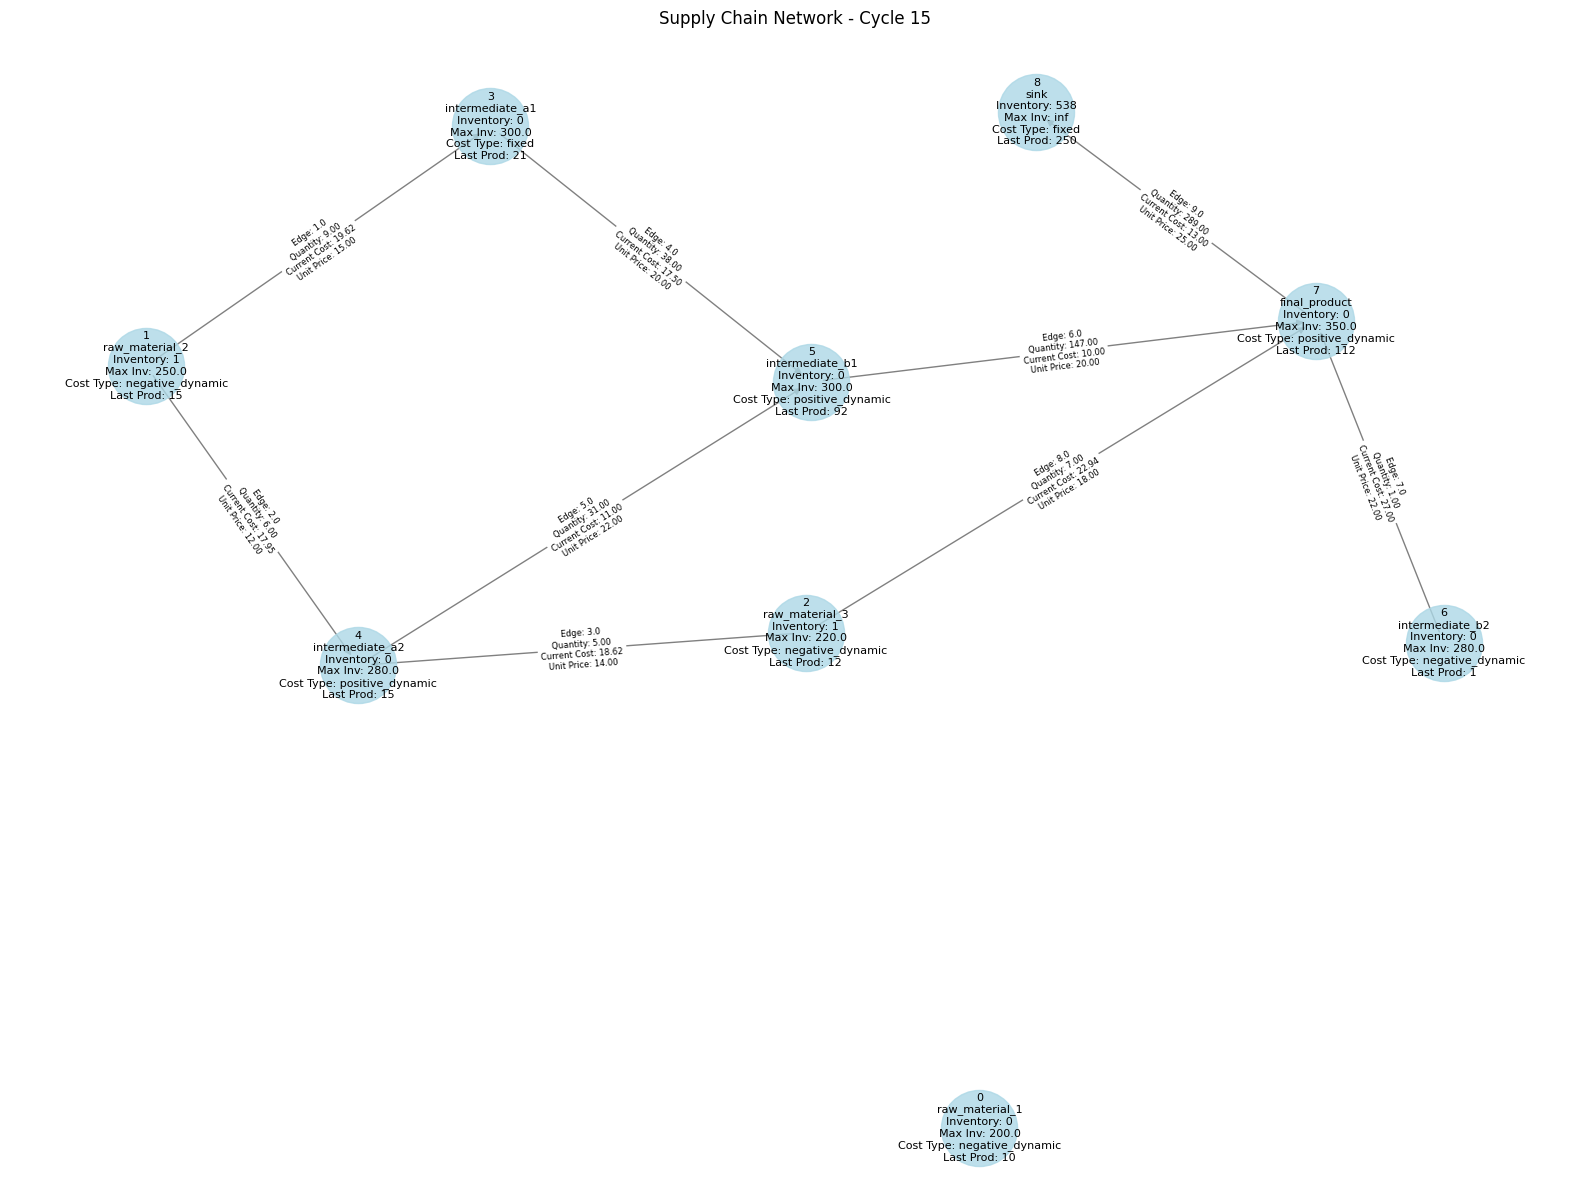

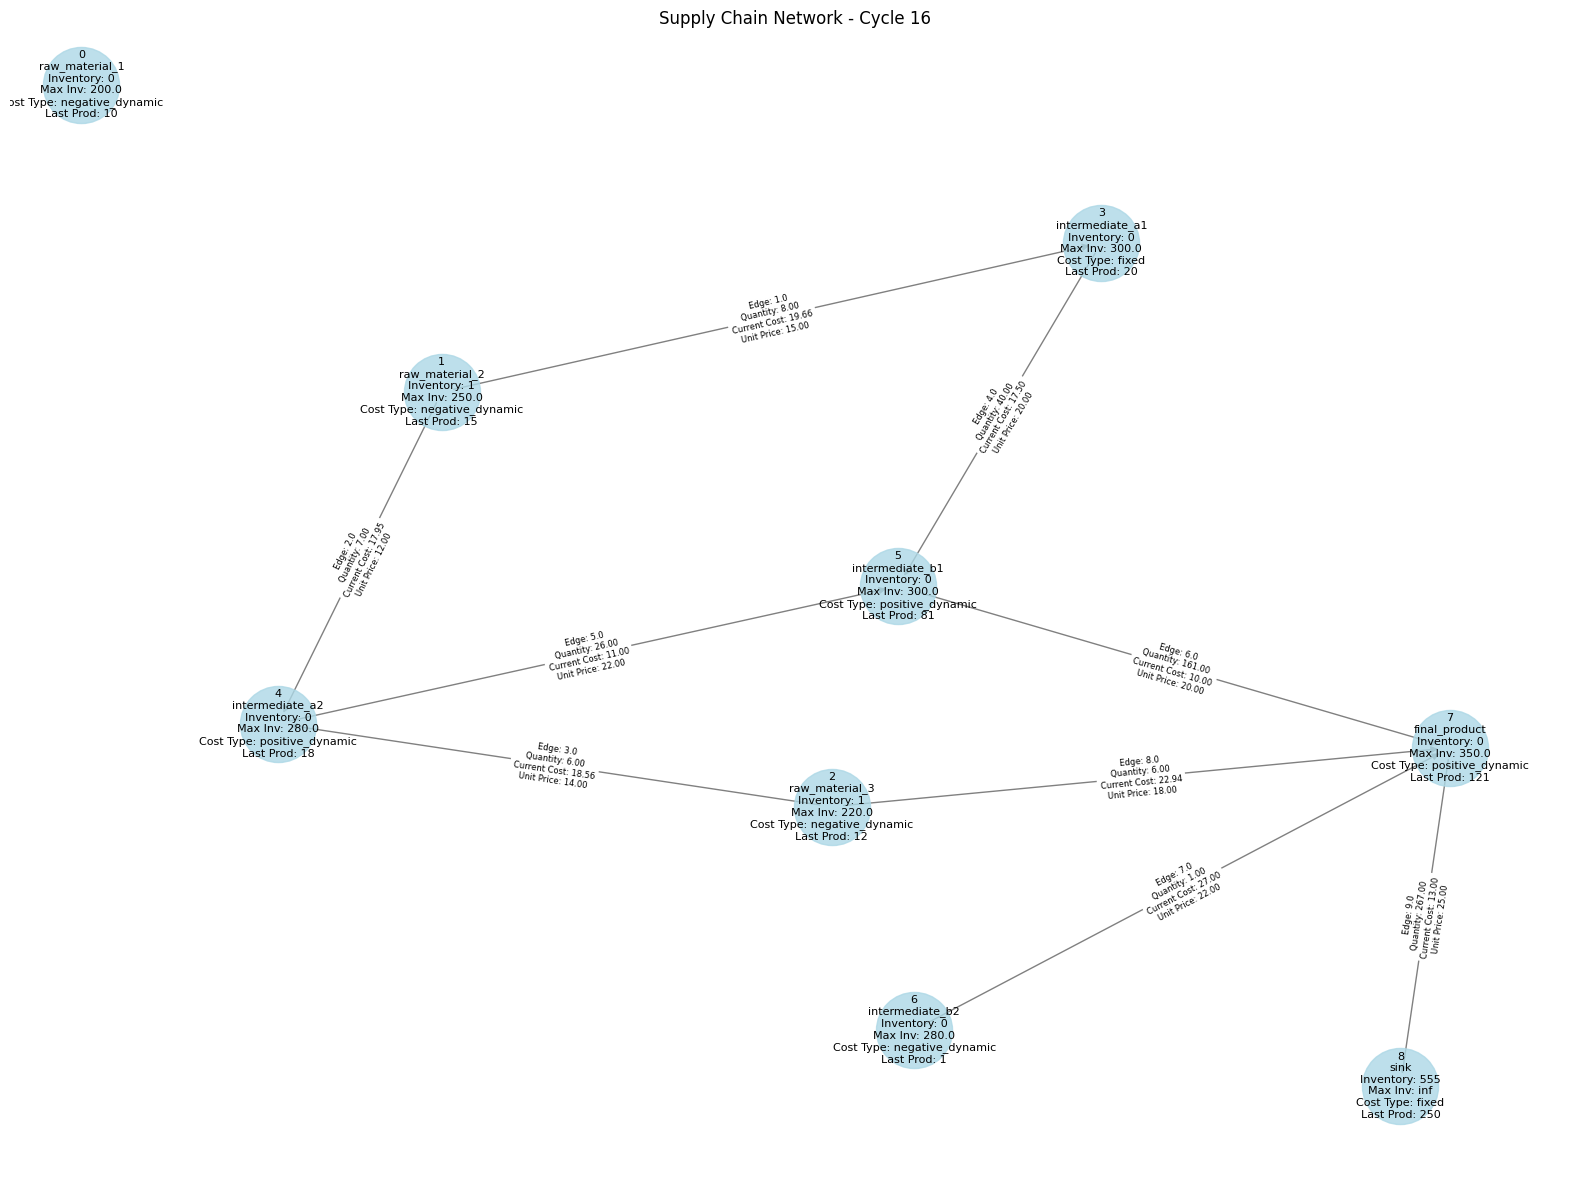

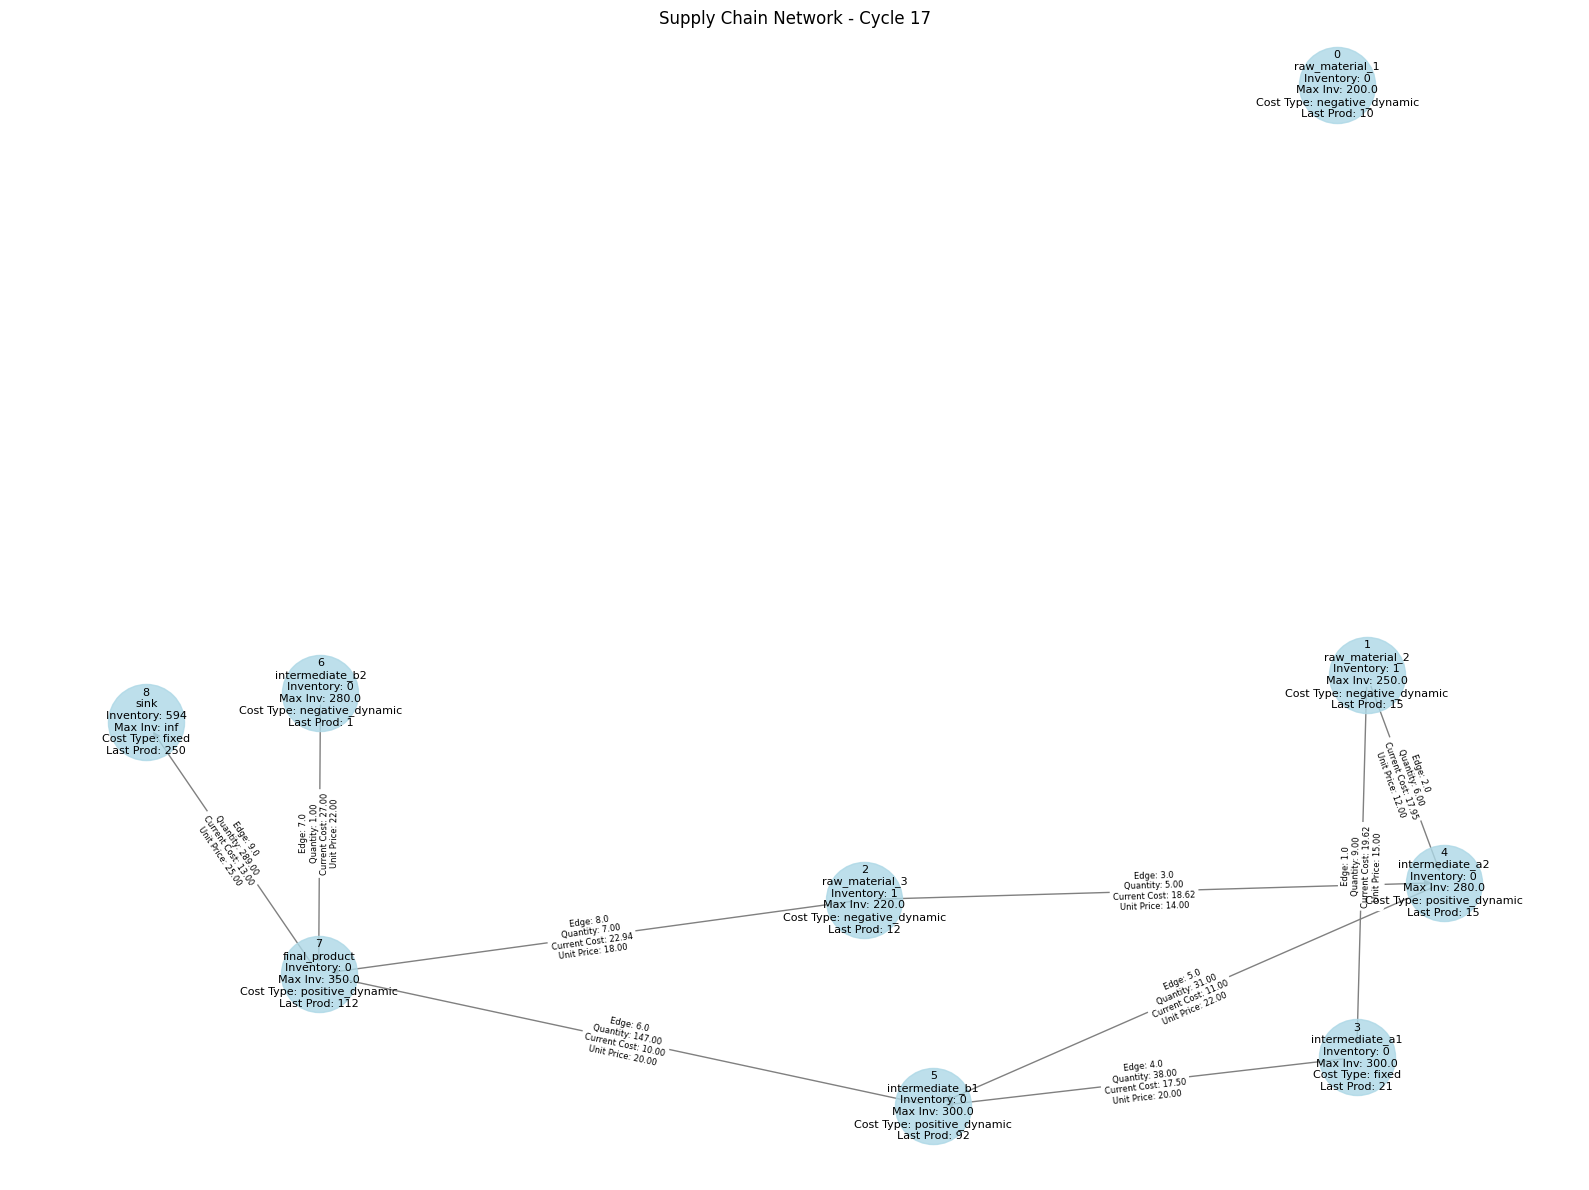

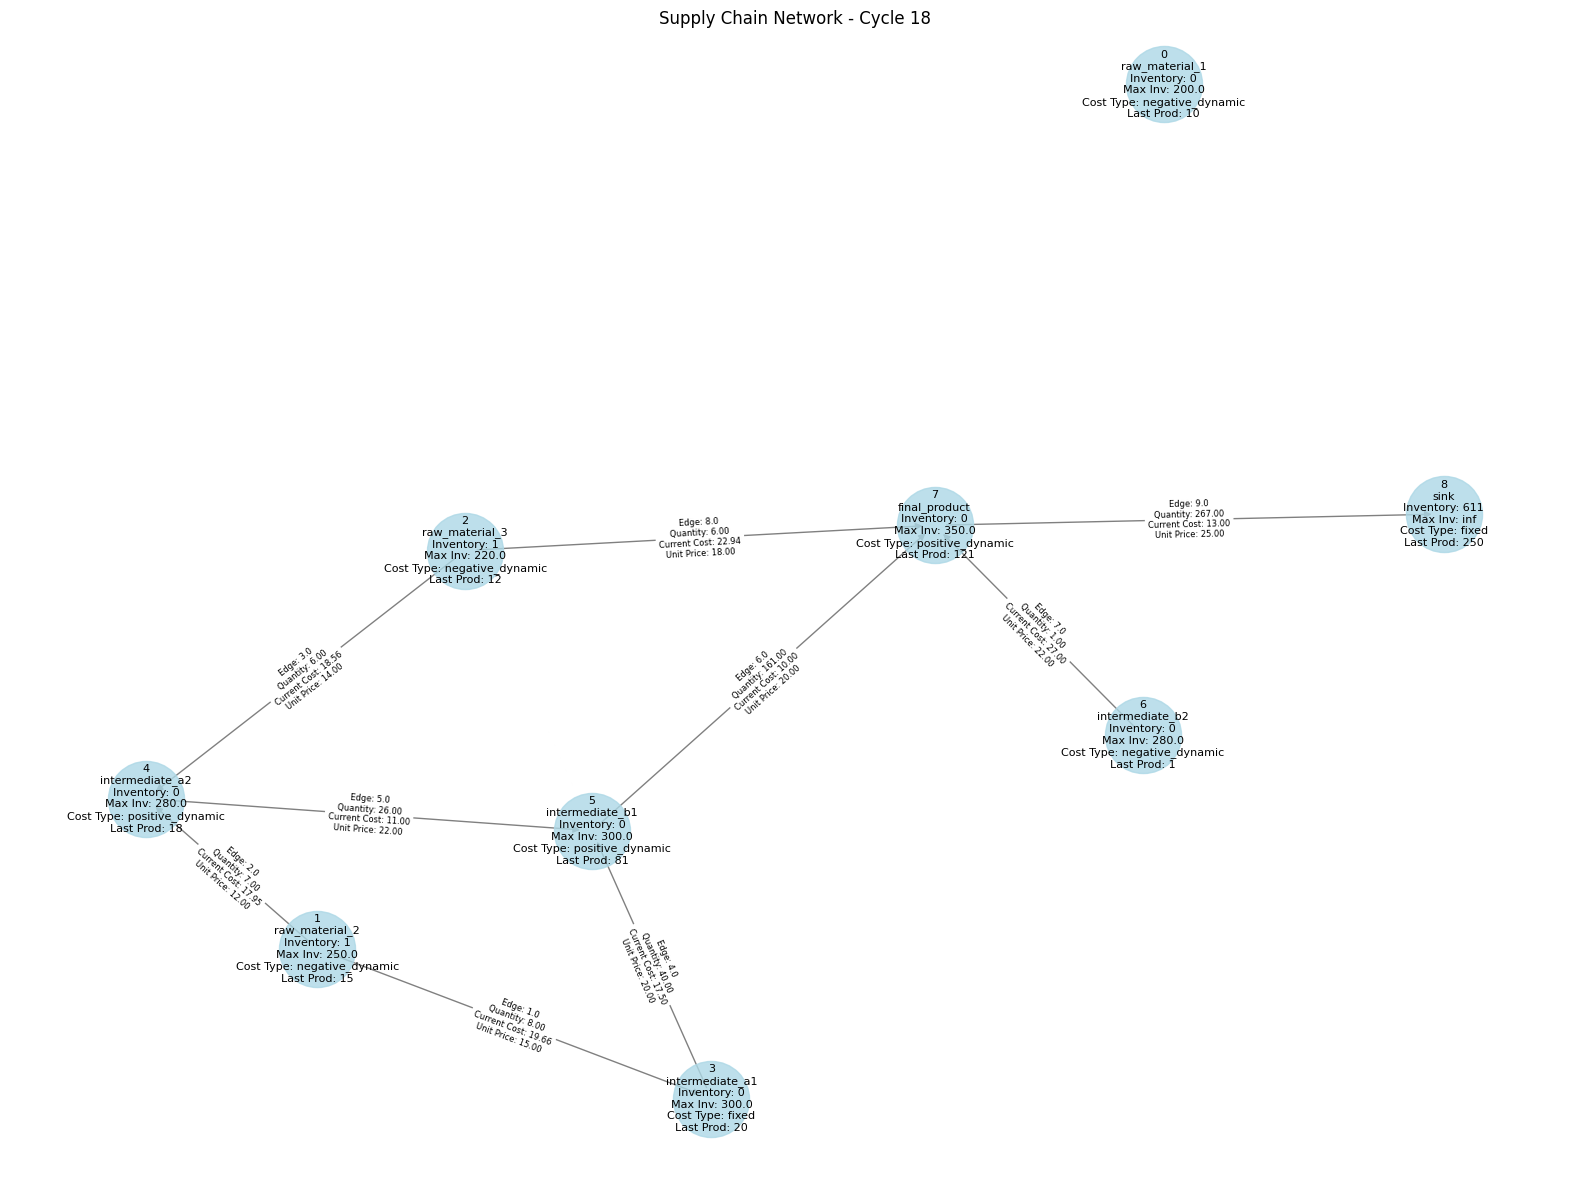

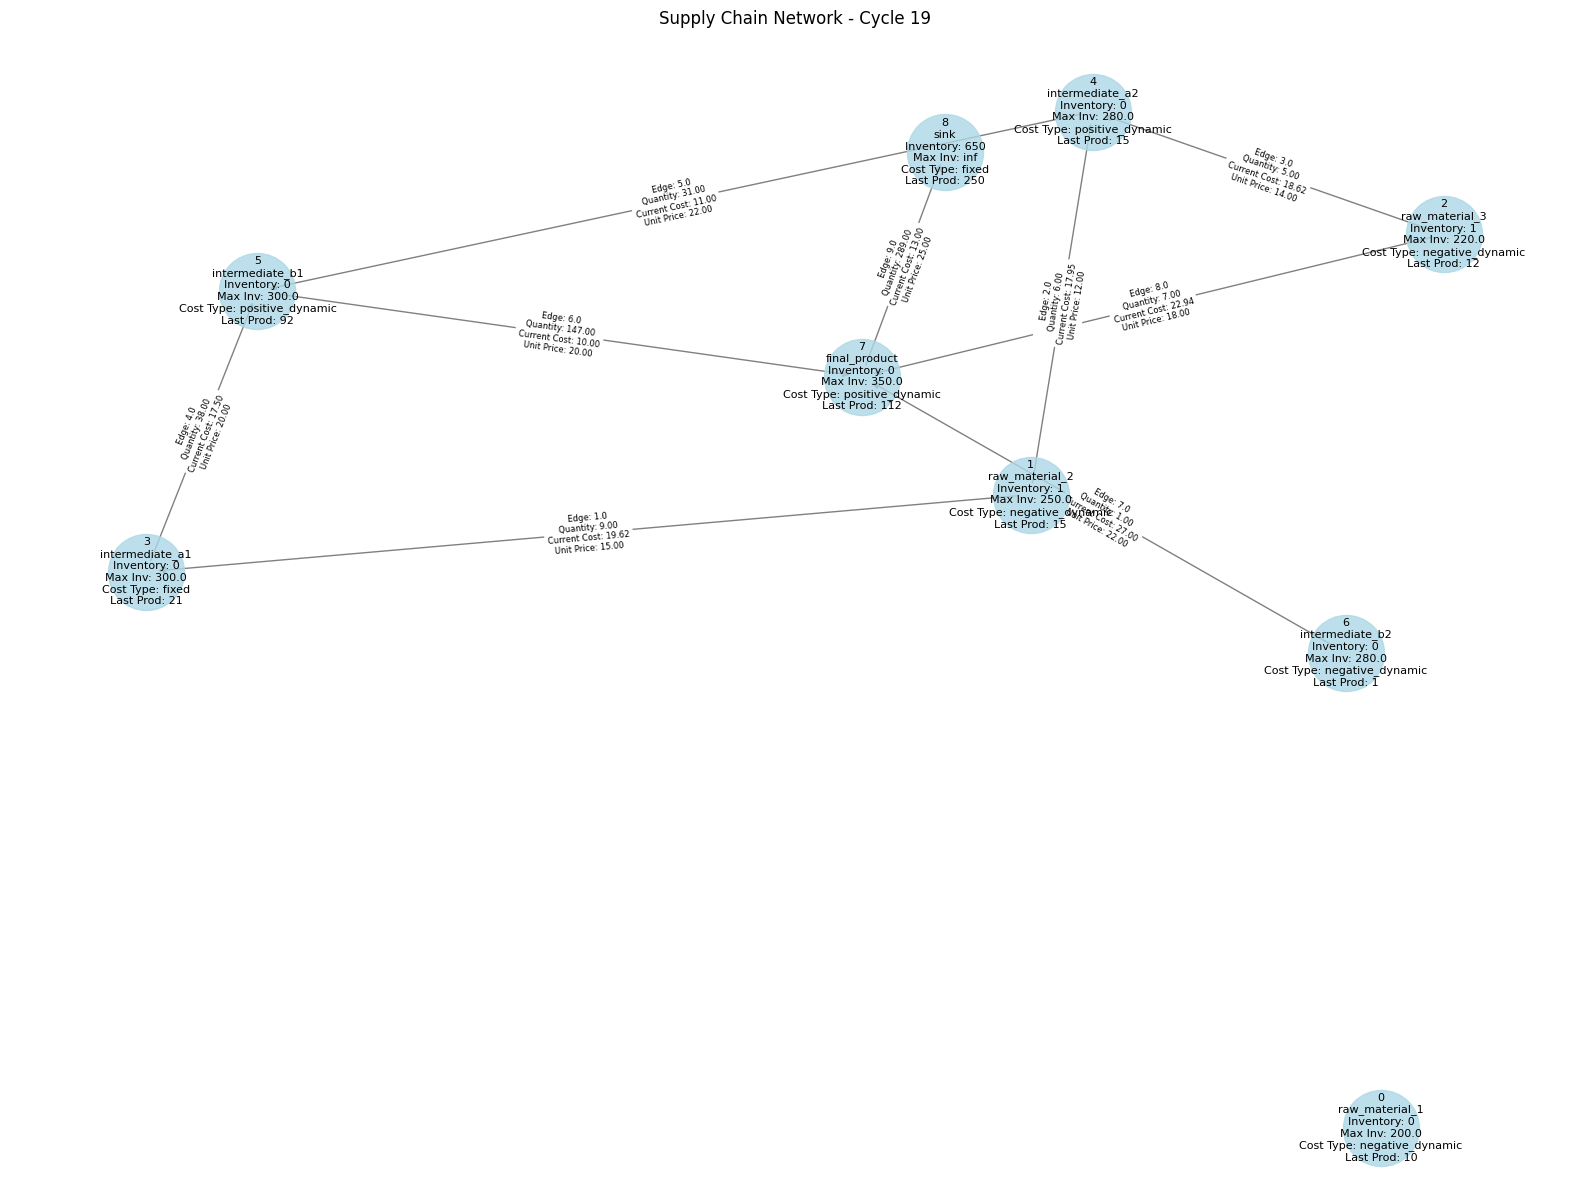

In [7]:
graphs = convert_to_graph(metadata, node_data, edge_data)
for i, G in enumerate(graphs):
    visualize_graph(G, i)